# Mapping single-cell transcriptomes to spatial transcriptomics

This notebook maps a reference RNA dataset onto an **image-based ST** dataset in zebrafish time-course data.

## Required inputs (2 datasets)
1. **ST dataset:** WeMERFISH zebrafish **75% epiboly (B_75p)**, embryo **E1** (AnnData `.h5ad`)
   - Data release: [Dryad (DOI: 10.5061/dryad.j0zpc86v9)](https://doi.org/10.5061/dryad.j0zpc86v9)
   - Mirror/archive: [Zenodo record](https://zenodo.org/records/15223126)

2. **Reference dataset:** in-house zebrafish scRNA-seq data, provided in two representations
   - **sc (single-cell):** original scRNA-seq cells (`adata_sc`)
   - **mc (metacell):** small, homogeneous groups of cells represented by a denoised, aggregated expression profile (`adata_mc`)

   **How sc and mc are used:**
   - The alignment/mapping step can use **either sc or mc** as the reference (`use_sc_data = "sc"` or `"mc"`).
   - **Metacells are still required even when mapping with sc**, because downstream steps build a **reference graph/structure** from metacells for stable global alignment.

   - Metacell construction resources:
     - [metacells GitHub](https://github.com/tanaylab/metacell)

Related resources:
- WeMERFISH processing code: [GitHub repo](https://github.com/yinan-wan0/weMERFISH)
- Project/resource page (includes publication link): [Vizgen resource page](https://vizgen.com/resources/whole-embryo-spatial-transcriptomics-at-subcellular-resolution-from-gastrulation-to-organogenesis/)

## Pipeline overview
1. **Preprocessing**: load data, subset by time, align shared genes.
2. **1:1 mapping**: assign each ST cell to its best-matching reference cell.
3. **Pairwise analysis**: find cell-type pairs that are often confused.
4. **Global FGW**: a global alignment using both expression similarity and dataset structure.
5. **Results**: visualize mapping quality and ambiguity.


In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import pickle
import os

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import mapping_sc_to_st

## 1. Preprocessing

- This section prepares the two datasets for mapping by making them comparable and ensuring required representations exist.


### Parameters and paths

This cell sets analysis parameters and input file paths.

Parameters:
- `st_time`, `st_batch`: choose the WeMERFISH dataset (e.g., `"75"`, `"E1"`)
- `use_sc_data`: mapping reference (`"sc"` or `"mc"`)
- `use_sc_data_time_point`: scRNA-seq time filter  
  Examples: `50p=(5.0, 5.67)`, `75p=(8.0, 8.4)`, `6s=(11.5, 12.4)`
- `exclude_st_cell_region`: ST clusters to remove  
  Example: `['YSL', 'Dorsal Forerunner Cells', 'Primordial Germ Cells']`

Paths:
- `path_st`: WeMERFISH AnnData `.h5ad` directory
- `path_sc`: in-house single-cell AnnData `.h5ad`
- `path_mc`: metacell AnnData `.h5ad`
- `metacell_graph`: reference graph file used downstream (generated by Metaflow)
- `cell_color_path`: user-defined cell-type color table (loaded as `cell_type_color`)

In [2]:
use_sc_data = 'sc' # 'sc' or 'mc'

exclude_st_cell_region = ['YSL', 'Dorsal Forerunner Cells', 'Primordial Germ Cells']

## file path
path_st = '/local/users/mmittnenzweig/spatiotemporal_zebrafish/data/weMerfish/AnnData_withImputation/'
path_mc = '/local/users/dlee/ST/data/timecourse_wt/timecourse_wt.metacells_celltypes-distance-2025-11-19.h5ad'
path_sc = "/local/users/dlee/ST/data/timecourse_wt/make_small_clusters_10_3_100.h5ad"
metacell_graph = '/local/users/dlee/ST/data/cell_type_mgraph.csv'
cell_color_path = '/local/users/dlee/ST/data/cell_type_colors-2025-11-19.csv'

cell_type_color = pd.read_csv(cell_color_path)

In [3]:
adata_sc = sc.read_h5ad(path_sc)
adata_mc = sc.read_h5ad(path_mc)
adata_st = sc.read_h5ad(path_st + 'B_75p_E1_with_imputation.h5ad')

In [4]:
st_mask = ~adata_st.obs["clusters"].isin(exclude_st_cell_region)
adata_st = adata_st[st_mask, :].copy()

### Filter cells and remove rare cell types

This cell applies three filters to make the mapping step stable and reproducible.

- **Reference time filter (scRNA-seq):** keep only cells whose `developmental_time` falls within `use_sc_data_time_point` (inclusive).
- **ST region filter:** remove ST clusters listed in `exclude_st_cell_region` (based on `adata_st.obs["clusters"]`).
- **Remove rare reference cell types:** `prep.filter_small_celltypes(...)` drops `cell_type` groups with fewer than `min_cells` cells (here, `< 20`).

**Why remove rare cell types?** Very small groups can lead to unstable/false matches and can also cause downstream errors in steps that require enough cells (e.g., DEG or mapping/statistics).


In [5]:
adata_sc, _ = mapping_sc_to_st.prep.filter_small_celltypes(
    adata_sc,
    groupby="cell_type",
    min_cells=2,
)

too small groups: []


### Prepare representations for FGW distance/cost options (`ensure_all_basic`)

This cell runs `prep.ensure_all_basic(...)` to **precompute and cache multiple representations**
that can later be used to define **distance / cost terms in FGW** (expression-based vs structure-based).

**Why here?**
FGW typically combines:
- a **structure/geometry distance** (e.g., spatial distances or graph-based distances), and
- an **expression distance** (e.g., in gene space or a denoised embedding).
This step prepares several interchangeable options so FGW can switch distance definitions without re-running heavy preprocessing.

#### What this function can create (options in `prep.ensure_all_basic`)
**Structure / geometry options (ST)**
- `make_spatial_normed=True`  
  - Ensures raw spatial coords exist in `adata_st.obsm["spatial"]`  
  - Creates `adata_st.obsm["spatial_normed"]` by dividing coordinates by the **median kNN distance** (k=`spatial_k`, here 10)  
  - Stores metadata in `adata_st.uns["spatial_norm_info"]`  
  - Typical use later: Euclidean distances in `spatial_normed` (stable scale across samples)

- `make_knn_st=True` (optional)  
  - Builds an ST neighbor graph (often on `spatial_normed`) via `scanpy.pp.neighbors`  
  - Typical use later: graph-based/geodesic distances instead of plain Euclidean

**Expression options (reference and/or ST)**
- `make_scvi=True` (reference) and `make_scvi_st=True` (ST)  
  - Trains scVI using `layer="counts"` (if present)  
  - Stores latent embeddings in:
    - reference: `adata_sc.obsm["X_scvi"]` (saved as `scvi_info_sc` in `.uns`)
    - ST: `adata_st.obsm["X_scvi"]` (key controlled by `st_latent_key`, info in `.uns["scvi_info_st"]`)  
  - Typical use later: expression distances in a denoised latent space (`X_scvi`)

- `make_nmf_sc / make_nmf_st` (optional)  
  - Creates NMF embeddings (default key `obsm["X_nmf"]`)  
  - Typical use later: alternative low-dimensional expression distance (often faster / simpler than scVI)

**Other optional utilities (mostly for exploration/plots)**
- `make_pca_sc`, `make_knn_sc`, `make_umap_sc`, `make_umap_st`  
  - Helpful for QC/visualization and graph construction on the reference side

#### Why the notebook branches on `use_sc_data`
- If `use_sc_data == "mc"`:
  - This cell computes **ST-side** representations (`spatial_normed`, ST scVI latent).
  - The reference latent is computed later after the reference is switched to metacells.
- If `use_sc_data == "sc"`:
  - This cell computes latents for **both** reference and ST.
  - `devices=[2]` selects which available compute device (e.g., GPU index) to use for scVI training.


In [6]:
if use_sc_data == 'mc':
    _ = mapping_sc_to_st.prep.ensure_all_basic(
        adata_sc,
        adata_st,
        make_spatial_normed=True,   
        spatial_k=10,
        
        make_scvi=False,
        
        make_scvi_st=True,         
        scvi_st_batch_key=None,     
        scvi_st_n_latent=64,
        scvi_st_max_epochs=200,
        scvi_st_counts_layer="counts",
        st_latent_key="X_scvi",
        model_device = 'gpu',
        accelerator = 'gpu',
        devices = [2]
    )

else:
    _ = mapping_sc_to_st.prep.ensure_all_basic(
        adata_sc,
        adata_st,
        st_xy_cols=None,     

        make_spatial_normed=True,   
        spatial_k=10,

        make_scvi=True,            
        scvi_batch_key=None,    
        scvi_counts_layer="counts", 
        scvi_n_latent=20,
        scvi_max_epochs=100,

        make_scvi_st=True,         
        scvi_st_batch_key=None,     
        scvi_st_n_latent=20,
        scvi_st_max_epochs=100,
        scvi_st_counts_layer="counts",
        st_latent_key="X_scvi",
        model_device = 'gpu',
        accelerator = 'gpu',
        devices = [2]
    )

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


start make_scvi


You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 100/100: 100%|██████████| 100/100 [02:27<00:00,  1.43s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.02e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:27<00:00,  1.48s/it, v_num=1, train_loss_step=1.03e+3, train_loss_epoch=1.02e+3]


### Align genes and prepare the metacell reference (`use_sc_data == "mc"`)

- **Align genes**
  - Subset both datasets to `common_gene` (the intersection of ST and reference genes) so all expression-based comparisons are done in the same gene space.

- **Store metacell 2D coordinates**
  - Save metacell coordinates from `obs[["x","y"]]` into `adata_mc.obsm["X_umap"]`, which is later used to draw the metacell graph (metagraph) in 2D.

- **Filter metacells by the time-selected single-cell composition**
  - Build `mask` by keeping only metacells whose `cell_type` appears in the **time-filtered single-cell reference** (`adata_sc` after `use_sc_data_time_point` filtering).  
  Metacells were constructed by aggregating single cells across the full time course (and the metacell set is small, so it is kept as a global reference across all times). After selecting a specific time window in the single-cell reference, the cell-type composition can differ; applying this mask restricts the metacell reference to cell types actually present at the selected time.

- **Switch to metacells as the reference**
  - Replace the reference object with metacells (`adata_sc = adata_mc`) so downstream mapping/alignment uses metacells as the reference unit.
  - Run `ensure_all_basic(..., make_scvi=True)` to create the metacell scVI latent (`adata_sc.obsm["X_scvi"]`, trained from the `"counts"` layer).  
    `devices=[2]` selects which available device index (e.g., GPU id) to use for training.
  - Finalize the metacell reference by applying `mask` and `common_gene` (`adata_sc = adata_sc[mask, common_gene]`).


In [7]:
common_gene = adata_st.var_names.intersection(adata_sc.var_names)
adata_sc = adata_sc[:, common_gene].copy()
adata_st = adata_st[:, common_gene].copy()

adata_mc.obsm['metacell_dist'] = adata_mc.obs[['x', 'y']].to_numpy()

all_cell_types = adata_sc.obs["cell_type"].astype(str).unique()
mask = adata_mc.obs["cell_type"].astype(str).isin(all_cell_types).to_numpy()

#mask = list(adata_sc.obs['metacell_name'].unique())
#mask = list(set(adata_mc.obs.index) & set(mask))

#mask = list(set(adata_mc.obs.index))

if use_sc_data == 'mc': 
    adata_sc = adata_mc
    _ = mapping_sc_to_st.prep.ensure_all_basic(
        adata_sc,
        adata_st,
        st_xy_cols=None,     

        make_spatial_normed=True,   
        spatial_k=10,

        make_scvi=True,            
        scvi_batch_key=None,    
        scvi_counts_layer="total_umis", 
        scvi_n_latent=512,
        scvi_max_epochs=200,
        model_device = 'gpu',
        accelerator = 'gpu',
        devices = [2],
        
        make_scvi_st=False,   
    )
    
    adata_sc = adata_sc[mask, common_gene].copy()

# 2. 1:1 mapping

- This section performs a **one-to-one mapping** from ST cells to reference cells/metacells.


### Select informative genes per cell type (DEG + HVG)

This cell calls `select_genes_per_celltype(...)` to build a cell-type-specific gene set by combining:
- **DEGs** (marker-like genes per cell type) and
- **HVGs** (highly variable genes computed within each cell type).

**Current settings**
- Grouping: `groupby="cell_type"`
- DEG (Scanpy `rank_genes_groups`):
  - `deg_method="wilcoxon"`, `deg_pval_cutoff=0.1`, `deg_logfc_cutoff=1.5`, `deg_n_genes=None`
- HVG (Scanpy `highly_variable_genes`):
  - `hvg_n_top_genes=40`, `hvg_flavor="seurat_v3"`, `hvg_layer=None`
- Merge rule: `mode="union"` (DEG ∪ HVG)

**Additional knobs supported by the function**
- DEG:
  - `deg_key_added`: store/read DEG results under a custom key in `adata.uns`
  - `deg_use_raw`: compute DEGs from `adata.raw` instead of `adata.X`
- HVG:
  - `hvg_warn_if_layer_none`: warn when `hvg_layer=None` (since HVG uses `adata.X`)
- Selection safety:
  - `min_selected_genes`: if `mode="intersection"` yields too few genes, fall back to union for that cell type

**HVG flavor options**
`hvg_flavor` is passed to Scanpy and can be:
- `"seurat"`, `"cell_ranger"`, `"seurat_v3"`, `"seurat_v3_paper"`

Scanpy expects **log-transformed** input for most flavors, but **expects count data** for `"seurat_v3"` / `"seurat_v3_paper"`.
In this notebook, `hvg_layer=None` means HVGs are computed from `adata.X` (often already log-normalized), so HVG selection may not be strictly count-based even when using `seurat_v3`.

**Outputs**
- `selected_genes`: a dict `{cell_type: DataFrame}` where the DataFrame index is the final selected gene list for that cell type (after applying `mode`).
- `deg_results`: a dict `{cell_type: DataFrame}` containing DEG statistics for that cell type (e.g., p-values / adjusted p-values / logFC, depending on what Scanpy provides).
- `hvg_results`: a dict `{cell_type: list[str]}` listing HVGs selected within that cell type.


### Normalize and log-transform (reference and ST)

Both datasets are processed with the same standard preprocessing:
- `sc.pp.normalize_total(..., target_sum=1e4)`: library-size normalization (per-cell total counts scaled to 10,000)
- `sc.pp.log1p(...)`: log-transform to stabilize variance

This makes expression values comparable across cells and between datasets (differences in sequencing depth / detection rate are reduced), which is important for downstream similarity computations and visualization.


In [9]:
if use_sc_data == 'mc':
    hvg_layer = 'total_umis'
else:
    hvg_layer = 'counts'

selected_genes, deg_results, hvg_results = mapping_sc_to_st.genes.select_genes_per_celltype(
                                                                    adata_sc,
                                                                    groupby="cell_type",
                                                                    
                                                                    # DEG parameters
                                                                    deg_method="wilcoxon",
                                                                    deg_n_genes=None,
                                                                    deg_pval_cutoff=0.1,
                                                                    deg_logfc_cutoff=1.5,
                                                                    
                                                                    # HVG parameters
                                                                    hvg_n_top_genes=40,
                                                                    hvg_flavor="seurat_v3",
                                                                    hvg_layer=None,
                                                                    # Gene selection rule
                                                                    mode="union",   # "union" or "intersection"
                                                                )

selected_genes_set = sorted({vv for v in selected_genes.values() for vv in v.index})

adata_sc = adata_sc[:, selected_genes_set].copy()
adata_st = adata_st[:, selected_genes_set].copy()

sc.pp.normalize_total(adata_sc, target_sum=1e4)
sc.pp.log1p(adata_sc)

sc.pp.normalize_total(adata_st, target_sum=1e4)
sc.pp.log1p(adata_st)

### Global top-1 mapping (SC cell → ST spot)

This cell calls `global_map.run_global_1to1_mapping(...)` to assign **one best-matching SC cell (top-1) to each ST spot** using a similarity score computed on a shared gene set.

The implementation is memory-friendly: it **does not build the full `(n_sc × n_st)` similarity matrix**. Instead, it processes SC cells in batches and keeps only the **current best match per ST spot** (best score and the SC index that achieved it).

**What you should expect from this step**
- Output is a **hard top-1 assignment per ST spot** (not a probabilistic mixture).
- Multiple ST spots can map to the **same** SC cell (this is not a strict bijection constraint).
- Results are written into `adata_st.obs` and `adata_st.uns`, and a summary dict `S` is returned.

**Current settings**
- Inputs:
  - `adata_sc`, `adata_st`, `selected_genes`
- SC label source:
  - `groupby_sc="cell_type"`
- Similarity:
  - `corr_method="pearson"` (options: `"spearman"`, `"pearson"`)
  - `cos_threshold=0.5` (options: `None` or `float`; gates correlation term)
- Performance:
  - `use_vectorized_batch=True` (options: `True`, `False`)
  - `n_jobs=128` (used only when `use_vectorized_batch=False`)
- Uncertainty handling:
  - `type_threshold=None` (options: `None` or `float`)
  - `uncertain_label="uncertain"` (used only when `type_threshold` is set)

**How similarity is computed (implementation details)**
The score for SC cell `i` vs ST spot `j` is:
- `sim(i, j) = 0.5 * cosine(exp_sc_i, exp_st_j) + 0.5 * corr(FC_sc_i, FC_st_j)`

Where:
- `exp_*` is taken from `adata[:, genes_union].X` on the final shared gene list
- `genes_union` is built from `selected_genes`, keeping only genes present in both datasets
- `baseline_sc` / `baseline_st` are per-gene means computed separately in SC and ST
- `FC_* = exp_* - baseline_*`
- `corr_method` options:
  - `"pearson"`: Pearson correlation on centered `FC`
  - `"spearman"`: Spearman correlation computed via per-row ranks

**Important notes (common gotchas)**
- `cos_threshold` gates the correlation term:
  - If `cos_threshold` is set, correlation is only computed/used where `cosine >= cos_threshold`.
  - In the non-vectorized path, if a given SC cell has `cosine < cos_threshold` for all ST spots, the function returns a cosine-only score for that SC cell (fast path).
- `use_vectorized_batch=True` is the default fast path:
  - It is numerically equivalent in intent, but tiny floating-point differences can occur compared to the loop implementation due to different accumulation order.
  - If you need strict historical behavior, set `use_vectorized_batch=False`.
- The function name includes “1to1”, but behavior is **top-1 per ST spot**, not a strict one-to-one matching constraint across the entire dataset.

**Parameter options (summary)**
- `selected_genes`: gene panel specification (must overlap both datasets)
  - Typical types: `list[str]`, `np.ndarray[str]`, `pd.Index`
  - Must yield a non-empty intersection with `adata_sc.var_names` and `adata_st.var_names`
- `groupby_sc`: `str`
  - Any `adata_sc.obs` column name (e.g., `"cell_type"`, `"subclass"`, `"cluster"`)
- `corr_method`: `{"spearman", "pearson"}`
- `cos_threshold`: `None` or `float`
  - `None`: correlation term is considered everywhere
  - `float`: correlation term is gated by cosine threshold
- `type_threshold`: `None` or `float`
  - If set: spots with `best_score < type_threshold` get their mapped type replaced by `uncertain_label`
- `uncertain_label`: `str` (label name used when applying `type_threshold`)
- `store_best_cell`: `bool` (default `True`)
  - If `True`, store best SC identity/index/type into `adata_st.obs`
- `sort_genes`: `bool` (default `True`) for stable `genes_union` ordering
- `precompute_sc_rank`: `bool` (default `True`)
  - Mainly beneficial when `corr_method="spearman"`
- `use_vectorized_batch`: `bool`
  - `True`: vectorized batch scoring (fast)
  - `False`: per-SC loop + joblib parallelism (uses `n_jobs`)
- `n_jobs`: `int` (used only if `use_vectorized_batch=False`)
- `sc_batch_size`: `int` or `None` (default `2048`)
  - Controls how many SC cells are processed per batch
- `eps`: `float` (default `1e-12`) numerical stability constant

**Outputs**
- Written to `adata_st.obs` (canonical keys from `keys` module):
  - `global_sc_sim`: best similarity score per ST spot
  - `global_sc_type`: mapped SC type per ST spot (thresholded only if `type_threshold` is set)
  - If `store_best_cell=True` (default):
    - `global_sc_best_cell`: best SC cell name (`adata_sc.obs_names`)
    - `global_sc_best_cell_idx`: best SC cell integer index
    - `global_sc_best_cell_type`: raw SC type of the best cell (before applying `type_threshold`)
- Written to `adata_st.uns`:
  - `global_sc_genes_union`: final gene list used for scoring
  - If `store_best_cell=True` and initialization succeeds:
    - `final_pairwise_weights`: a per-spot “degenerate mixture” container:
      - `sc_idx=[best_sc_idx]`, `w=[1.0]`, plus `score`, `best_type`, and `model="global_1to1"`
      - Used by downstream refinement steps that expect a unified weights dict
- Returned value:
  - `S`: a dict holding the top-1 mapping results and precomputations:
    - `best_sc_idx`: `(n_spots,)` int array; best SC index for each ST spot
    - `best_score`: `(n_spots,)` float array; best similarity score per ST spot
    - `best_cell`: `(n_spots,)` array; best SC cell name per spot (`adata_sc.obs_names[best_sc_idx]`)
    - `best_type_raw`: `(n_spots,)` array; SC label from `adata_sc.obs[groupby_sc]` for the best cell
    - `best_type`: `(n_spots,)` array; final mapped type after optional thresholding to `uncertain_label`
    - `precomp`: dict of cached arrays used for scoring (e.g., `genes_union`, FC buffers, and rank/center/std buffers depending on `corr_method`)


In [10]:
S = mapping_sc_to_st.global_map.run_global_1to1_mapping(
    adata_sc,
    adata_st,
    selected_genes,
    groupby_sc="cell_type",
    n_jobs=128,
    cos_threshold=0.5,
    uncertain_label="uncertain",
    use_vectorized_batch=True,
    corr_method = "pearson",  # "spearman" | "pearson"
)

# 3. Pairwise Comparison

This section refines the initial **global top-1 mapping** by explicitly addressing two practical issues that often cause systematic errors when mapping scRNA-seq to ST:

1. **Bleeding / contamination genes can bias the mapping**
   - In image-based ST (and many spot-based assays), some genes “bleed” across neighboring regions or appear as ambient contamination.
   - These genes can look like strong markers in scRNA-seq but appear **flattened or spread** in ST, which can push a spot toward the wrong cell type.
   - Pairwise refinement identifies such **directional bleeding genes** between confusing cell-type pairs and reduces their influence during scoring.

2. **scRNA and ST may not be perfectly aligned along developmental time**
   - Even in time-course datasets, the sampled scRNA reference and the ST slice may represent slightly different or mixed time states.
   - A single SC cell (hard top-1) can be too restrictive; a spot can be better explained by a **mixture of multiple SC cells** representing an intermediate or shifted state.
   - Pairwise refinement uses **FGW-based transport** to produce per-spot mixture weights, which helps recover these “in-between” states more robustly than a single-cell assignment.

### High-level workflow in this notebook
1. **Choose which cell-type pairs to refine**
   - Load a cell-type metanode graph from Excel (nodes = cell types, edges = related/confusable pairs).
   - Select the strongest edges (top pairs) to focus computation on the most relevant confusions.

2. **Estimate directional bleeding genes for the selected pairs**
   - Compute directional bleeding statistics `ct1 → ct2` and `ct2 → ct1`.
   - Build an “incoming union” list of genes that are likely to be contaminated in ST for each type context.

3. **Refine each selected pair using FGW**
   - For each pair `(ct1, ct2)`, consider ST spots whose **global type** is `ct1` or `ct2`.
   - Remove or down-weight bleeding genes **directionally** (depending on which side of the pair is being modeled).
   - Solve an FGW problem to obtain a transport plan, then convert it into **per-spot mixture weights** over SC cells.
   - Decide the refined type per spot based on the mixture mass (with tie-breaking rules).

4. **Handle types not covered by selected pairs**
   - For cell types that never appeared in the selected pair list, run a single-type refinement (`refine_single_ct`) so that every type has a pairwise-stage score/type.

5. **Merge refinements into a single pairwise-stage result**
   - Merge all per-pair and per-type refinement outputs into `adata_st.obs` as a unified result:
     - `final_pairwise_type`, `final_pairwise_score`
   - Optionally only overwrite when the refinement improves the score.


### Plot a cell-type metanode graph (from Excel) with SC/MC input switching

This cell calls `fig.plot_celltype_metanode_graph(...)` to load a **cell-type-level metanode graph** from an Excel file and visualize it on a 2D embedding (e.g., UMAP).  
A key detail in this notebook is that the `adata` input depends on which representation you want to use:

- If `use_sc_data == "mc"`: use **single-cell AnnData** as the plotting/layout source  
  - `adata = adata_sc`
- If `use_sc_data == "sc"`: use **metacell AnnData** as the plotting/layout source  
  - `adata = adata_mc`

This matters because the function reads:
- cell-type labels from `adata.obs[ct_key]`, and
- 2D coordinates from `adata.obsm[obsm_key]`.

**Current settings**
- Plotting/layout source (depends on `use_sc_data`):
  - `adata = adata_sc` if `use_sc_data == "mc"`
  - `adata = adata_mc` if `use_sc_data == "sc"`
- Type labels / embedding:
  - `ct_key="cell_type"` (read from `adata.obs["cell_type"]`)
  - `obsm_key="X_umap"` (read from `adata.obsm["X_umap"]`)
- Graph input:
  - `excel_path=metacell_graph` (Excel file containing the metanode graph)
  - `graph_key="mf_graph"` (identifier/name for this graph)
- Coloring:
  - `cell_type_color=cell_type_color` (mapping: cell type → color)
- Reference-based filtering (optional but enabled here):
  - `adata_type_ref=adata_st`
  - `ref_ct_key="global_sc_type"`
  - `use_ref_intersection=True` (keep only cell types present in both `adata` and the reference)

**Important notes**
- The naming of `use_sc_data` can be confusing:
  - In this notebook convention, `"mc"` means “use the SC AnnData (`adata_sc`)”
  - and `"sc"` means “use the metacell AnnData (`adata_mc`)”
  Make sure to follow the above mapping consistently throughout the notebook.
- `use_ref_intersection=True` is recommended when the reference (`adata_st`) does not contain all cell types present in `adata`:
  - It restricts the graph to shared types only, improving comparability and avoiding missing-type artifacts.

**Outputs**
- `fig`, `ax`: Matplotlib figure/axis containing the metanode graph overlay.
- `A_df`: DataFrame describing the processed graph connectivity (adjacency or weights; format depends on implementation).
- `mgraph_df`: DataFrame describing the processed graph (typically an edge list with source/target/weight and metadata).


[INFO] allowed_types count = 28
[INFO] kept cells = 1358, kept types = 28


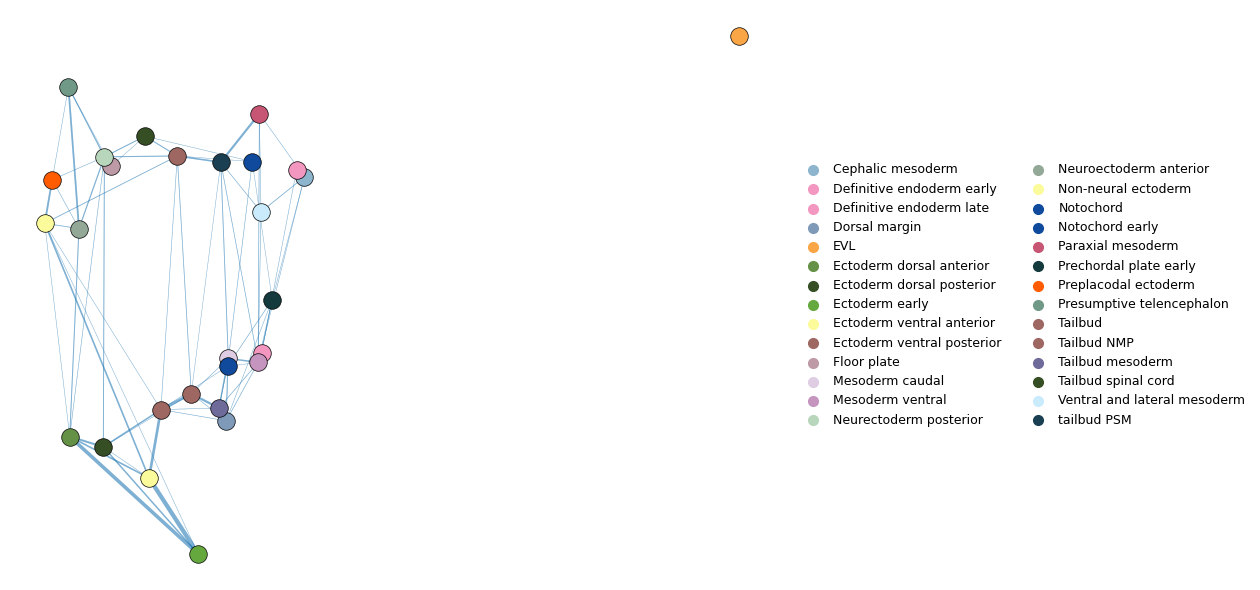

In [11]:
fig, ax, A_df, mgraph_df = mapping_sc_to_st.fig.plot_celltype_metanode_graph(
    adata=adata_mc,
    cell_type_color=cell_type_color,
    excel_path=metacell_graph,  
    adata_type_ref=adata_st,
    ref_ct_key="global_sc_type",
    use_ref_intersection=True,
    graph_key="mf_graph",
    ct_key="cell_type",
    obsm_key="X_umap",           
)


In [12]:
pairs_df = mapping_sc_to_st.pairwise_refine.select_type_pairs_from_A(A_df, top_n=1000, undirected=True, drop_self=True)
pairs_selected = list(pairs_df[["type_a", "type_b"]].itertuples(index=False, name=None))

### Compute directional bleeding genes and per-type incoming (contamination) gene sets

This cell calls `bleeding.compute_directional_bleeding(...)` to estimate **directional bleeding genes** between selected cell-type pairs, then summarizes them into **incoming gene sets** per target type using `bleeding.compute_incoming_union(...)`.

This step is used to reduce systematic mapping errors in ST caused by spatial spillover/ambient contamination: genes that are strong markers in scRNA-seq can appear “flattened” or broadly present in ST, which can bias global (top-1) mapping. By identifying such genes **directionally** (source → target), later pairwise refinement (e.g., FGW) can down-weight or remove them.

#### 1) Gene panel used for bleeding (how `selected_genes` becomes `genes`)

The function does not use all genes. It starts from the per-cell-type gene sets stored in `selected_genes` (typically DEG/HVG-derived) and builds a global panel:

- Per-type selected set: $G_c = \{g \mid g \in \text{selected_genes}[c].index\}$
- Union across types:
$$
  G_{\text{union}}=\bigcup_{c} G_c
$$
- Optional restriction by `genes_use`:
$$
G_{\text{use}}=
\begin{cases}
G_{\text{union}} \cap \mathrm{genes_use}, & \text{if genes_use is provided}\\
G_{\text{union}}, & \text{if genes_use is None}
\end{cases}
$$
- Final panel used for computations (must exist in both datasets):
$$
G = G_{\text{use}} \cap \text{var}(\text{adata_sc}) \cap \text{var}(\text{adata_st})
$$
If $G=\varnothing$, the function fails early (no valid overlapping genes).


#### 2) Cell types and ST spot filtering used to compute means

Only “valid” cell types are considered. A cell type must have enough samples in both datasets:

- SC count constraint:
$$
| \{ i : \mathrm{sc\_ct}(i)=c \} | \ge \mathrm{min\_cells\_sc}
$$
- ST count constraint is applied only on “high-confidence” spots:
$$
\mathrm{st\_high}(j) = \mathbf{1}\{\mathrm{st\_sim}(j) \ge \mathrm{st\_sim\_min}\}
$$
$$
| \{ j : \mathrm{st\_ct}(j)=c \land \mathrm{st\_high}(j)=1 \} | \ge \mathrm{min\_cells\_st}
$$
The valid set is the intersection of SC-valid and ST-valid types.

#### 3) Directional bleeding definition (FC-collapse rule)

For each directed pair $(c_{\text{src}}, c_{\text{tgt}})$ and each gene $g \in G$, the function computes per-type means:

$$
\mu^{sc}_{c,g} = \frac{1}{N^{sc}_c}\sum_{i:\,sc\_ct(i)=c} x^{sc}_{i,g}
$$
$$
\mu^{st}_{c,g} = \frac{1}{N^{st}_c}\sum_{j:\,st\_ct(j)=c \land st\_high(j)=1} x^{st}_{j,g}
$$

Directional log fold-change (natural log) in each dataset:
$$
\log FC^{sc}(g; src\!\to\!tgt)=\log\frac{\mu^{sc}_{src,g}+\epsilon}{\mu^{sc}_{tgt,g}+\epsilon}
$$
$$
\log FC^{st}(g; src\!\to\!tgt)=\log\frac{\mu^{st}_{src,g}+\epsilon}{\mu^{st}_{tgt,g}+\epsilon}
$$

SC marker-like mask (source markers only):
$$
\text{Marker}_{sc}(src\!\to\!tgt,g)=
\mathbf{1}\{\log FC^{sc}(g;src\!\to\!tgt)>\tau_{sc}^{pos}\}\;\land\;\mathbf{1}\{g\in DEG(src)\}
$$

Bleeding gene rule (source → target):
- Default (`use_abs_st=True`):
$$
\text{Bleed}(src\!\to\!tgt,g)=\text{Marker}_{sc}(src\!\to\!tgt,g)\;\land\;\mathbf{1}\{|\log FC^{st}(g;src\!\to\!tgt)|<\tau_{st}^{flat}\}
$$
- Directional-only option (`use_abs_st=False`):
$$
\text{Bleed}(src\!\to\!tgt,g)=\text{Marker}_{sc}(src\!\to\!tgt,g)\;\land\;\mathbf{1}\{\log FC^{st}(g;src\!\to\!tgt)<\tau_{st}^{flat}\}
$$

Interpretation:
- A gene is considered “bleeding from src to tgt” if it is a strong SC marker for `src` (vs `tgt`), but the ST contrast between `src` and `tgt` is weak/flat.

#### 4) Incoming genes per target type (how `incoming_genes` is built)

This notebook call uses `bleeding.compute_incoming_union(bleed)` with defaults:
- `incoming_mode="from_collapse"`

So incoming genes are derived directly from the bleeding sets:
$$
\text{IncomingUnion}(tgt)=\bigcup_{src\ne tgt}\{g:\text{Bleed}(src\!\to\!tgt,g)=1\}
$$

This gives a per-target “incoming contamination” gene set that can later be subtracted or down-weighted when refining spots assigned to that target type.


**Current settings**
- SC/ST inputs:
  - `groupby_sc="cell_type"`
  - `st_type_key="global_sc_type"`, `st_sim_key="global_sc_sim"`
  - `st_sim_min=0.3`
- Pair scope:
  - `pairs_selected=pairs_selected` (evaluates only these pairs; internally expanded bidirectionally)
- Gene scope:
  - `selected_genes=selected_genes`
  - `genes_use=None` (use union of `selected_genes`, then intersect with SC/ST var names)
- Minimum sample sizes:
  - `min_cells_sc=2`, `min_cells_st=20`
- Thresholds / stability:
  - `eps=1e-6`
  - `tau_sc_pos=1.0`, `tau_st_flat=0.2`
  - `use_abs_st=True` (default in the function)

**Parameter options to know**
- `use_abs_st`: `True` (default) or `False`
  - `True`: uses `|logFC_st| < tau_st_flat` for “flatness”
  - `False`: uses `logFC_st < tau_st_flat` for directional-only flatness
- `pairs_selected`: can be extended to cover more confusable pairs; if `None`, the function evaluates all directed permutations of valid types.
- `incoming_mode` in `compute_incoming_union`:
  - `"from_collapse"` (default): incoming is exactly the union of bleeding genes entering each target type
  - `"cross_layer"` (legacy): uses an additional cross-layer test
    $$
    B_{in}(tgt,g)=\log\frac{\mu^{st}_{tgt,g}+\epsilon}{\mu^{sc}_{tgt,g}+\epsilon}
    $$
    and marks incoming when `Marker_sc(src→tgt,g)` and $B_{in}(tgt,g)>\tau_{in}$

**Outputs**
- `bleed`: a dict containing:
  - `genes`, `celltypes_valid`, `mu_sc`, `mu_st`
  - `logFC_sc[(src,tgt)]`, `logFC_st[(src,tgt)]`
  - `is_sc_marker[(src,tgt)]` (boolean mask over genes)
  - `bleeding_pairs[(src,tgt)]` (set of gene names flagged as bleeding)
- `incoming_genes`: a dict containing:
  - `incoming_pairs[(src,tgt)]` and `incoming_per_target[tgt]` (the per-target incoming union used downstream)


In [13]:
bleed = mapping_sc_to_st.bleeding.compute_directional_bleeding(
    adata_sc,
    adata_st,
    selected_genes = selected_genes,
    groupby_sc="cell_type",
    st_type_key="global_sc_type",
    st_sim_key="global_sc_sim",
    pairs_selected = pairs_selected,
    st_sim_min=0.3,
    genes_use=None,
    min_cells_sc=2,
    min_cells_st=20,
    eps=1e-6,
    tau_sc_pos=1.0,
    tau_st_flat=0.2,
)

incoming_genes = mapping_sc_to_st.bleeding.compute_incoming_union(bleed)

### Visualize directional bleeding for a specific pair (FC scatter)

This cell calls `fig.plot_fc_scatter_by_pair(...)` to inspect directional bleeding for specific cell-type pairs using a gene-wise FC scatter plot.

Each point is a gene \(g\). The plot compares how strongly \(g\) separates the two types in **SC** versus how strongly it separates them in **ST**. This is a quick sanity check that the bleeding genes match the intended pattern: strong separation in SC but collapsed/flat separation in ST.

**Current settings**
- Inputs: `bleed`, `selected_genes`
- Thresholds shown on the plot:
  - `tau_sc_pos=1.0`
  - `tau_st_flat=0.2`
- Pairs to plot (extendable list):
  - `pairs=[("Mesoderm ventral", "Notochord early")]`

**What is plotted (formulas)**
For a directed pair $(src, tgt)$:
$$
\log FC^{sc}(g; src\!\to\!tgt)=\log\frac{\mu^{sc}_{src,g}+\epsilon}{\mu^{sc}_{tgt,g}+\epsilon}
$$
$$
\log FC^{st}(g; src\!\to\!tgt)=\log\frac{\mu^{st}_{src,g}+\epsilon}{\mu^{st}_{tgt,g}+\epsilon}
$$
Typically:
- x-axis: $\log FC^{sc}(g; src\!\to\!tgt)$
- y-axis: $\log FC^{st}(g; src\!\to\!tgt)$

**How to interpret the thresholds**
- SC marker region:
$$
\log FC^{sc}(g;src\!\to\!tgt) > \tau_{sc}^{pos}
$$
- ST “flatness” region (common default when bleeding was computed with `use_abs_st=True`):
$$
|\log FC^{st}(g;src\!\to\!tgt)| < \tau_{st}^{flat}
$$
Genes that satisfy both are consistent with the bleeding pattern (marker-like in SC, but flat in ST).

**Outputs**
- `fig`: Matplotlib figure object.


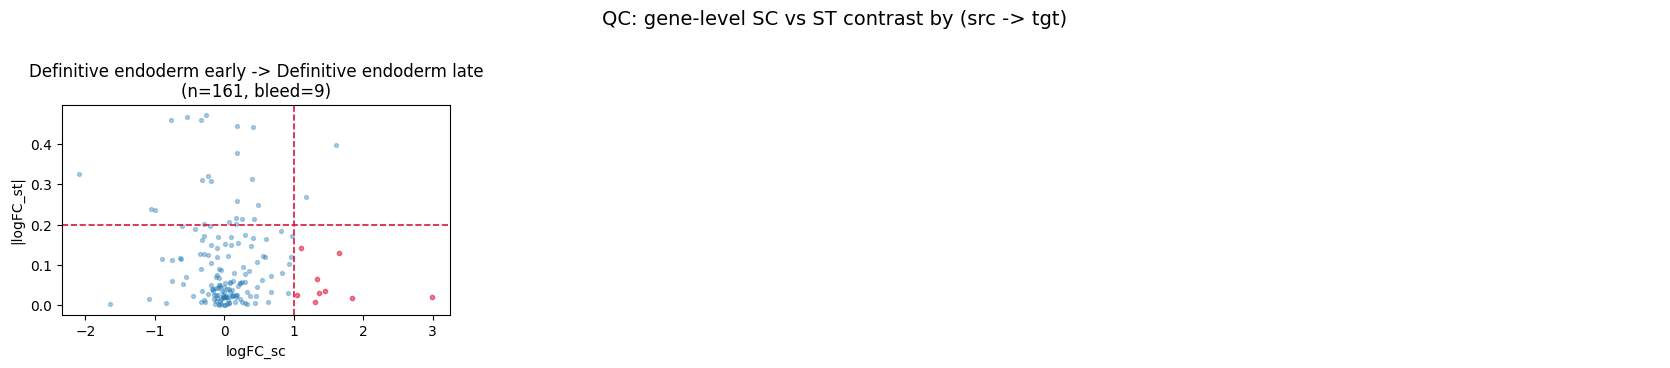

In [14]:
fig = mapping_sc_to_st.fig.plot_fc_scatter_by_pair(
    bleed,
    selected_genes,
    tau_sc_pos=1.0,     
    tau_st_flat=0.2,    
    pairs=[('Definitive endoderm early', 'Definitive endoderm late')],
)

### POTFGWSolver

This cell instantiates `fgw_solver.POTFGWSolver(...)`, a thin wrapper around POT (Python Optimal Transport) solvers for the **Fused Gromov–Wasserstein (FGW)** family. It is later used to compute a transport plan between SC and ST that can represent an ST spot as a **mixture of multiple SC cells**.

#### 1. Fused Gromov–Wasserstein (FGW) problem

FGW finds a coupling matrix $T$ between two domains by jointly considering:
- cross-domain **feature cost** $M$ (SC–ST feature mismatch), and
- within-domain **geometries** $C_{\mathrm{sc}}$, $C_{\mathrm{st}}$ (SC–SC and ST–ST structure).

A standard FGW objective is:
$$
\min_{T \in \Pi(p, q)}
(1-\alpha)\,\langle M, T \rangle
\;+\;
\alpha \, \mathcal{L}_{GW}(C_{\mathrm{sc}}, C_{\mathrm{st}}, T)
$$
where:
- $M \in \mathbb{R}^{n_{\mathrm{sc}} \times n_{\mathrm{st}}}$: feature cost between SC and ST samples
- $C_{\mathrm{sc}} \in \mathbb{R}^{n_{\mathrm{sc}} \times n_{\mathrm{sc}}}$, $C_{\mathrm{st}} \in \mathbb{R}^{n_{\mathrm{st}} \times n_{\mathrm{st}}}$: intra-domain geometry matrices
- $p \in \Delta^{n_{\mathrm{sc}}}$, $q \in \Delta^{n_{\mathrm{st}}}$: source/target marginals (weights)
- $\alpha \in [0,1]$: trade-off between feature matching and structure preservation
- $T \in \mathbb{R}_+^{n_{\mathrm{sc}} \times n_{\mathrm{st}}}$: transport plan (coupling)

Here $\Pi(p,q)=\{T \ge 0 \mid T\mathbf{1}=p,\;T^\top\mathbf{1}=q\}$ is the set of couplings with fixed marginals.

#### 2. Supported solver methods

`POTFGWSolver` wraps the following FGW-family solvers from POT:

- **`"fgw"`** : [`ot.gromov.fused_gromov_wasserstein`](https://pythonot.github.io/gen_modules/ot.gromov.html#ot.gromov.fused_gromov_wasserstein)  
  Standard FGW solved by conditional gradient (Frank–Wolfe).

- **`"entropic_fgw"`** : [`ot.gromov.entropic_fused_gromov_wasserstein`](https://pythonot.github.io/gen_modules/ot.gromov.html#ot.gromov.entropic_fused_gromov_wasserstein)  
  FGW with entropic regularization for improved numerical stability.

- **`"bapg_fgw"`** : [`ot.gromov.BAPG_fused_gromov_wasserstein`](https://pythonot.github.io/gen_modules/ot.gromov.html#ot.gromov.BAPG_fused_gromov_wasserstein)  
  FGW solved via Bregman Alternating Projected Gradient.

- **`"semirelaxed_fgw"`** : [`ot.gromov.semirelaxed_fused_gromov_wasserstein`](https://pythonot.github.io/gen_modules/ot.gromov.html#ot.gromov.semirelaxed_fused_gromov_wasserstein)  
  FGW with relaxed marginal constraints on one domain.

- **`"entropic_semirelaxed_fgw`"**: [`ot.gromov.entropic_semirelaxed_fused_gromov_wasserstein`](https://pythonot.github.io/gen_modules/ot.gromov.html#ot.gromov.entropic_semirelaxed_fused_gromov_wasserstein)
  semirelaxed FGW with entropic regularization for improved numerical stability.

- **`"fugw"`** : [`ot.gromov.fused_unbalanced_gromov_wasserstein`](https://pythonot.github.io/gen_modules/ot.gromov.html#ot.gromov.fused_unbalanced_gromov_wasserstein)  
  FGW with unbalanced (soft) marginal constraints.

#### 3. Entropic FGW (used in this notebook)

In the entropic variant, the objective includes an additional entropy term:
$$
\min_{T \in \Pi(p, q)}
(1-\alpha)\,\langle M, T \rangle
\;+\;
\alpha \, \mathcal{L}_{GW}(C_{\mathrm{sc}}, C_{\mathrm{st}}, T)
\;+\;
\epsilon \sum_{i,j} T_{ij}(\log T_{ij}-1)
$$
- $\epsilon > 0$ controls the strength of entropic regularization.
- Larger $\epsilon$ typically yields smoother $T$ (more diffuse mixtures) and better numerical stability.
- Smaller $\epsilon$ typically yields sharper $T$ (more concentrated matches) but can be harder to optimize.

#### 4. Current settings (this cell)

- `method="entropic_fgw"` (options: `"fgw"`, `"entropic_fgw"`, `"bapg_fgw"`, `"semirelaxed_fgw"`, `"fugw"`)
- `alpha=0.5` (options: any float in $[0,1]$)
  - $\alpha \rightarrow 0$: mostly feature matching via $M$
  - $\alpha \rightarrow 1$: mostly structure matching via $C_{\mathrm{sc}}, C_{\mathrm{st}}$
- `loss_fun="square_loss"` (options: `"square_loss"` and other POT-supported GW losses)
  - `"square_loss"` is the common default for GW/FGW in POT.
- `epsilon=0.1` (used when `method="entropic_fgw"`; options: any positive float)

Commented (optional) settings shown in the cell:
- `max_iter`: maximum outer iterations
- `max_iter_ot`: maximum inner OT iterations (entropic/Bregman loops)
- Unbalanced options (relevant when using `"fugw"` or other unbalanced solvers):
  - `unbalanced_solver`, `reg_marginals`, `divergence`

#### 5. What the solver returns (conceptually)

When called later with $(M, C_{\mathrm{sc}}, C_{\mathrm{st}}, p, q)$, the solver returns a transport plan $T$.
From $T$, we can derive spot-wise mixtures, for example:
- SC weights for a fixed ST spot $j$: $w^{(j)}_i \propto T_{ij}$
- A hard label can be recovered by $\arg\max_i T_{ij}$, but the main benefit is keeping the full mixture.


In [27]:
solver = mapping_sc_to_st.fgw_solver.POTFGWSolver(
    method="entropic_fgw",
    alpha=0.5,
    loss_fun="square_loss",
    epsilon = 0.1,
    #max_iter=2,     
    #max_iter_ot=2,   
    #unbalanced_solver="mm",
    #reg_marginals=10.0,
    #divergence="kl",
)


#### Pairwise FGW refinement for selected cell-type pairs

This block runs **pairwise refinement** for each selected cell-type pair, then runs a **single-type fallback** for any remaining cell types not covered by the pair list, and finally **merges** all refinement results into unified per-spot outputs in `adata_st`.

This description intentionally omits the anchor-based cost path (`use_anchor_cost`, `anchor_key`) because it is implemented but not used in this notebook.

#### A) Pairwise refinement loop: `pairwise_refine.refine_pair_ct1_ct2(...)`

For each `(ct1, ct2)` in `pairs_selected`, the function refines only the ST spots currently labeled as either `ct1` or `ct2` by the global mapping, using FGW to compute **spot-specific mixtures of SC cells**.

##### Parameter summary (as used here)

- `ct1`, `ct2`:
  - The two cell types to be refined against each other.
  - Only SC cells with these types and ST spots with global type in `{ct1, ct2}` are considered.

- `bleeding_obj=bleed`:
  - Output of `bleeding.compute_directional_bleeding(...)`.
  - Used to remove direction-specific bleeding genes when `bleeding_mode="bleeding"`.

- `bleeding_mode` (options: `"bleeding"`, `"incoming"`, `"none"`):
  - `"bleeding"` (used here): removes directional bleeding genes `ct1→ct2` and `ct2→ct1` with different masks for the two models.
  - `"incoming"`: removes per-target incoming genes (requires `incoming_obj`).
  - `"none"`: no gene removal; uses the full union gene panel.

- `groupby_sc="cell_type"`:
  - SC type labels are read from `adata_sc.obs[groupby_sc]`.
  - Must include `ct1` and `ct2` as values.

- `sc_geom_obsm_key="X_scvi"`, `st_geom_obsm_key="X_scvi"`:
  - Keys in `adata_sc.obsm` and `adata_st.obsm` providing coordinates used to build geometry costs.
  - Typically 2D/latent embeddings; Euclidean distances form $C_{sc}$ and $C_{st}$.

- `solver=solver`:
  - A configured `POTFGWSolver` instance (here: entropic FGW).
  - Controls which POT routine is used and how strongly transport is regularized (e.g., `epsilon`).

- `precomp=S["precomp"]`:
  - Precomputed arrays for fast scoring on the global union gene panel.
  - Must include `genes_union` and the normalized expression buffers used by cosine/correlation scoring.

- `cos_threshold=0.5`:
  - Gates the correlation term in the score.
  - If cosine similarity is below this threshold, the code skips correlation and uses cosine-only scoring.

- `score_n_jobs=128`:
  - Parallelism used by the non-vectorized scoring path (implementation-dependent).
  - If scoring is vectorized inside `precomp`, this may be ignored.

- `mass_tie_eps=0`:
  - Tie tolerance for mass-based type decision.
  - If the mixture mass assigned to `ct1` and `ct2` differs by at most `mass_tie_eps`, a tie-break rule is applied.

#### B) What the function computes (no-anchor path)

##### 1) Corridor subset (SC and ST)
Let the global ST type key be `"global_sc_type"`.

- ST corridor:
  - $I_{st}=\{j \mid \mathrm{type}^{st}_{global}(j)\in\{ct1,ct2\}\}$
- SC corridor:
  - $I_{sc}=\{i \mid \mathrm{type}^{sc}(i)\in\{ct1,ct2\}\}$, where $\mathrm{type}^{sc}(i)=\texttt{adata\_sc.obs[groupby\_sc]}$

##### 2) Gene panel + directional bleeding masks
Base gene panel:
- $G=\mathrm{precomp["genes\_union"]}$

With `bleeding_mode="bleeding"`:
- $B_{1\to 2}=\mathrm{bleeding\_obj["bleeding\_pairs"][(ct1,ct2)]}$
- $B_{2\to 1}=\mathrm{bleeding\_obj["bleeding\_pairs"][(ct2,ct1)]}$

Directional gene sets:
- ct1-model: $G_1 = G \setminus B_{1\to 2}$
- ct2-model: $G_2 = G \setminus B_{2\to 1}$

##### 3) Geometry costs $C_{sc}$, $C_{st}$
Using embeddings:
- $z^{sc}=\mathrm{adata\_sc.obsm["X\_scvi"][}I_{sc}\texttt{]}$
- $z^{st}=\mathrm{adata\_st.obsm["X\_scvi"][}I_{st}\texttt{]}$

Euclidean geometry costs:
- $C_{sc}(i,i')=\lVert z^{sc}_i - z^{sc}_{i'}\rVert_2$
- $C_{st}(j,j')=\lVert z^{st}_j - z^{st}_{j'}\rVert_2$

##### 4) Feature cost $M$
For each model $k\in\{1,2\}$:
- $M^{(k)}(i,j)=\lVert x^{sc}_{k,i} - x^{st}_{k,j}\rVert_2^2$
- $M^{(k)} \leftarrow \dfrac{M^{(k)}}{s(M^{(k)})+\epsilon}$

##### 5) FGW solve and per-spot mixture
With uniform marginals:
- $p_i=1/|I_{sc}|$, $q_j=1/|I_{st}|$

Solve entropic FGW to obtain coupling $T$, then normalize columns:
- $W_{ij}=\dfrac{T_{ij}}{\sum_{i'}T_{i'j}+\epsilon}$

This yields a spot-specific mixture over SC cells for each spot.

##### 6) Mixture-based scoring and selection
Mixture expression:
- $\hat{x}_j=\sum_i W_{ij}\,x^{sc}_i$

Score:
- $\mathrm{score}_j = 0.5\cdot \cos_j + 0.5\cdot \mathrm{corr}_j$


Per spot, the code selects the higher-score model (ct1-model vs ct2-model) and then decides `ct1` vs `ct2` by comparing mixture mass:
- $m_1=\sum_{i\in ct1} W_{ij}$, $m_2=\sum_{i\in ct2} W_{ij}$

#### C) Single-type fallback: `pairwise_refine.refine_single_ct(...)`

After the pairwise loop, any cell type that appears in `adata_st.obs["global_sc_type"]` but not in any pair is refined using `refine_single_ct(...)`.

##### Parameter summary (as used here)
- `ct`:
  - The single cell type to refine.
- `groupby_sc="cell_type"`:
  - SC labels column.
- `sc_geom_obsm_key="X_scvi"`, `st_geom_obsm_key="X_scvi"`:
  - Geometry embeddings for FGW.
- `C_kind_sc="distnace"`:
  - Geometry kind selector used by the implementation (note the literal spelling).
- `solver=solver`:
  - Same FGW solver configuration.
- `precomp=S["precomp"]`, `cos_threshold=0.5`, `score_n_jobs=128`:
  - Same scoring configuration as pairwise.

The single-type function runs one FGW solve and updates per-spot scores; the label stays `ct` unless the implementation applies a minimum-score filter.


#### D) Merge all refinements into unified per-spot outputs: `merge.merge_refinements(...)`

After collecting all refinement results in `out`, this cell merges them into a single pairwise-stage result stored in `adata_st`.



In [28]:
out = []

for c_type1, c_type2 in tqdm(pairs_selected):
    rr = mapping_sc_to_st.pairwise_refine.refine_pair_ct1_ct2(
        adata_sc,
        adata_st,
        ct1=c_type1,
        ct2=c_type2,
        #selected_genes= selected_genes,
        bleeding_obj=bleed,                 # output of compute_bleeding_directional
        #selected_genes = selected_genes,
        #incoming_obj=incoming_genes,                
        bleeding_mode="bleeding",          # "bleeding" | "incoming" | "none"
        groupby_sc="cell_type",
        # geometry for FGW (C_sc, C_st)
        sc_geom_obsm_key= "X_scvi",
        st_geom_obsm_key= "X_scvi",
        #sc_C_mode = "metacell_distance",
        # anchor cost
        use_anchor_cost=False,
        anchor_key="X_global_sc_anchor",
        beta_expr=0.7,
        # solver
        solver=solver,
        # scoring
        precomp=S['precomp'],       
        cos_threshold=0.5,
        score_n_jobs=128,
        # decisions
        mass_tie_eps=0)
    out.append(rr)
    
used_cell_type = []
all_cell_types = adata_st.obs["global_sc_type"].astype(str).unique()

for c_type1, c_type2 in pairs_selected:
    if c_type1 not in used_cell_type:
        used_cell_type.append(c_type1)
    if c_type2 not in used_cell_type:
        used_cell_type.append(c_type2)

ex_cell_type = set(all_cell_types) - set(used_cell_type)

for ct in ex_cell_type:
    rr = mapping_sc_to_st.pairwise_refine.refine_single_ct(
            adata_sc,
            adata_st,
            ct = ct,
            groupby_sc="cell_type",
            # geometry for FGW (C_sc, C_st)
            sc_geom_obsm_key= "X_scvi",
            st_geom_obsm_key="X_scvi",
            C_kind_sc = 'distnace',
            # anchor cost
            use_anchor_cost=False,
            beta_expr=0.7,
            # solver
            solver=solver,
            # scoring
            precomp=S['precomp'],       
            cos_threshold=0.5,
            score_n_jobs=128,
        )
    out.append(rr)
    
merge_result = mapping_sc_to_st.merge.merge_refinements(
    adata_st,
    out,
    overwrite=True,
    only_when_improved=True,
    #backup_prev=True,
)

100%|██████████| 72/72 [02:14<00:00,  1.86s/it]


### Select final ST anchors per type (high-confidence + diverse coverage)

This cell calls `anchors.select_st_anchors_final(...)` to pick a set of **anchor ST spots** that will be used as stable, high-confidence representatives of each cell type in later steps.

Anchor selection is based on two principles:
1. **Confidence**: pick spots with high mapping scores within each type.
2. **Diversity**: avoid picking anchors that are all clustered in the same region of the embedding/space.

#### What is selected

Given:
- type labels: `adata_st.obs[st_type_key]`
- mapping scores: `adata_st.obs[st_score_key]`
- geometry coordinates: `adata_st.obsm[st_geom_key]`

the function returns:
- `idx_anchor`: a 1D array of selected ST spot indices (global indices in `adata_st`)
- `anchors_by_type`: a dict mapping each type `t` to its selected anchor indices

#### Core selection logic (code-level, with formulas)

For each cell type $t$:

##### 1) Candidate set
Let:
- $I_t = \{ j \mid \mathrm{type}(j)=t \}$

Exclude invalid entries:
- spots with `type` missing / `"None"` / `"nan"` are ignored
- spots with score missing are ignored

If $|I_t| < \mathrm{min\_per\_type}$, the type contributes no anchors (or contributes fewer, depending on implementation).

##### 2) Score-based filtering (top fraction)
Let the score be $s_j$ for spot $j$.

The top-fraction candidate pool is:
$$
I_t^{top} = \text{Top}\left(I_t,\; \lceil \mathrm{top\_frac\_per\_type}\cdot |I_t|\rceil \right)
$$
where `Top` means take the spots with largest $s_j$.

Then enforce minimum pool size:
$$
|I_t^{top}| \leftarrow \max(|I_t^{top}|,\; \mathrm{min\_per\_type})
$$

##### 3) Diversity-aware downsampling in geometry space
Let $z_j \in \mathbb{R}^d$ be the embedding coordinate of spot $j$ from `adata_st.obsm[st_geom_key]` (here: `X_scvi`).

The function discretizes the embedding into a grid with `diversity_bins` bins per axis (implementation typically uses per-dimension binning by quantiles or min–max ranges).

Define a grid cell assignment:
$$
g(j) = \mathrm{bin}(z_j) \in \{1,\dots,B\}^d,\quad B=\mathrm{diversity\_bins}
$$

Within each grid cell, keep at least:
- `diversity_min_per_grid` spots, prioritizing higher scores.

Formally, for each grid cell $G$:
$$
I_{t,G} = \{ j \in I_t^{top} \mid g(j)=G \}
$$
select:
$$
A_{t,G} = \text{Top}\left(I_{t,G},\; \mathrm{diversity\_min\_per\_grid}\right)
$$

Let:
$$
A_t^{div} = \bigcup_G A_{t,G}
$$

##### 4) Final cap per type
Finally cap the number of anchors per type:
$$
A_t = \text{Top}\left(A_t^{div},\; \mathrm{n\_anchor\_per\_type}\right)
$$
If $|A_t|$ is still smaller than requested (e.g., due to few candidates), the function returns all available anchors for that type.

#### Current settings

- `st_type_key="final_pairwise_type"`
  - Anchors are chosen per type after the pairwise merge stage.
- `st_score_key="final_pairwise_score"`
  - Confidence uses the final pairwise score per spot.
- `st_geom_key="X_scvi"`
  - Diversity is enforced in the `X_scvi` embedding space.

Per-type selection knobs:
- `n_anchor_per_type=30`
  - Target maximum anchors per type.
- `top_frac_per_type=0.3`
  - Only consider the top 30% scoring spots per type before enforcing diversity.
- `min_per_type=2`
  - Ensure each type contributes at least 2 anchors if possible.
- `diversity_bins=12`
  - Grid resolution used to diversify anchors across the embedding space.
- `diversity_min_per_grid=1`
  - Keep at least 1 anchor per occupied grid cell (score-prioritized).

#### Parameter options (practical guidance)

- `n_anchor_per_type` (int):
  - Increase to use more anchors (more coverage, more compute downstream).
  - Decrease for speed and stricter anchor quality.

- `top_frac_per_type` (float in $(0,1]$):
  - Smaller values make anchors more conservative (only very high-confidence).
  - Larger values include more candidates, which can help if scores are noisy.

- `min_per_type` (int):
  - Prevents rare types from being dropped entirely.
  - Set to 0 if you prefer to omit low-support types.

- `diversity_bins` (int):
  - Larger bins → stronger spatial/embedding diversification (but can reduce anchors if data are sparse).
  - Smaller bins → weaker diversification (anchors may cluster).

- `diversity_min_per_grid` (int):
  - Usually 1. Increase if you want multiple anchors per region (requires enough candidates).

- `st_geom_key` (str):
  - Any embedding in `adata_st.obsm` can be used (`"X_umap"`, `"X_pca"`, `"X_scvi"`, etc.).
  - Use a representation consistent with your refinement geometry if you want anchors to reflect the same structure.

- `st_type_key`, `st_score_key` (str):
  - Allows anchor selection from any stage (global vs pairwise vs final), as long as the keys exist.

#### Outputs

- `idx_anchor`:
  - 1D array of selected ST indices (union over types).
- `anchors_by_type`:
  - dict `{type: np.ndarray(indices)}` with per-type anchor sets.


In [29]:
idx_anchor, anchors_by_type = mapping_sc_to_st.anchors.select_st_anchors_final(
    adata_st,
    n_anchor_per_type=20,               
    top_frac_per_type=0.1,            
    min_per_type=2,                  
    diversity_bins=12,                  
    diversity_min_per_grid=1,
    st_geom_key= 'X_scvi',  
    st_type_key="final_pairwise_type",       
    st_score_key="final_pairwise_score", 
)

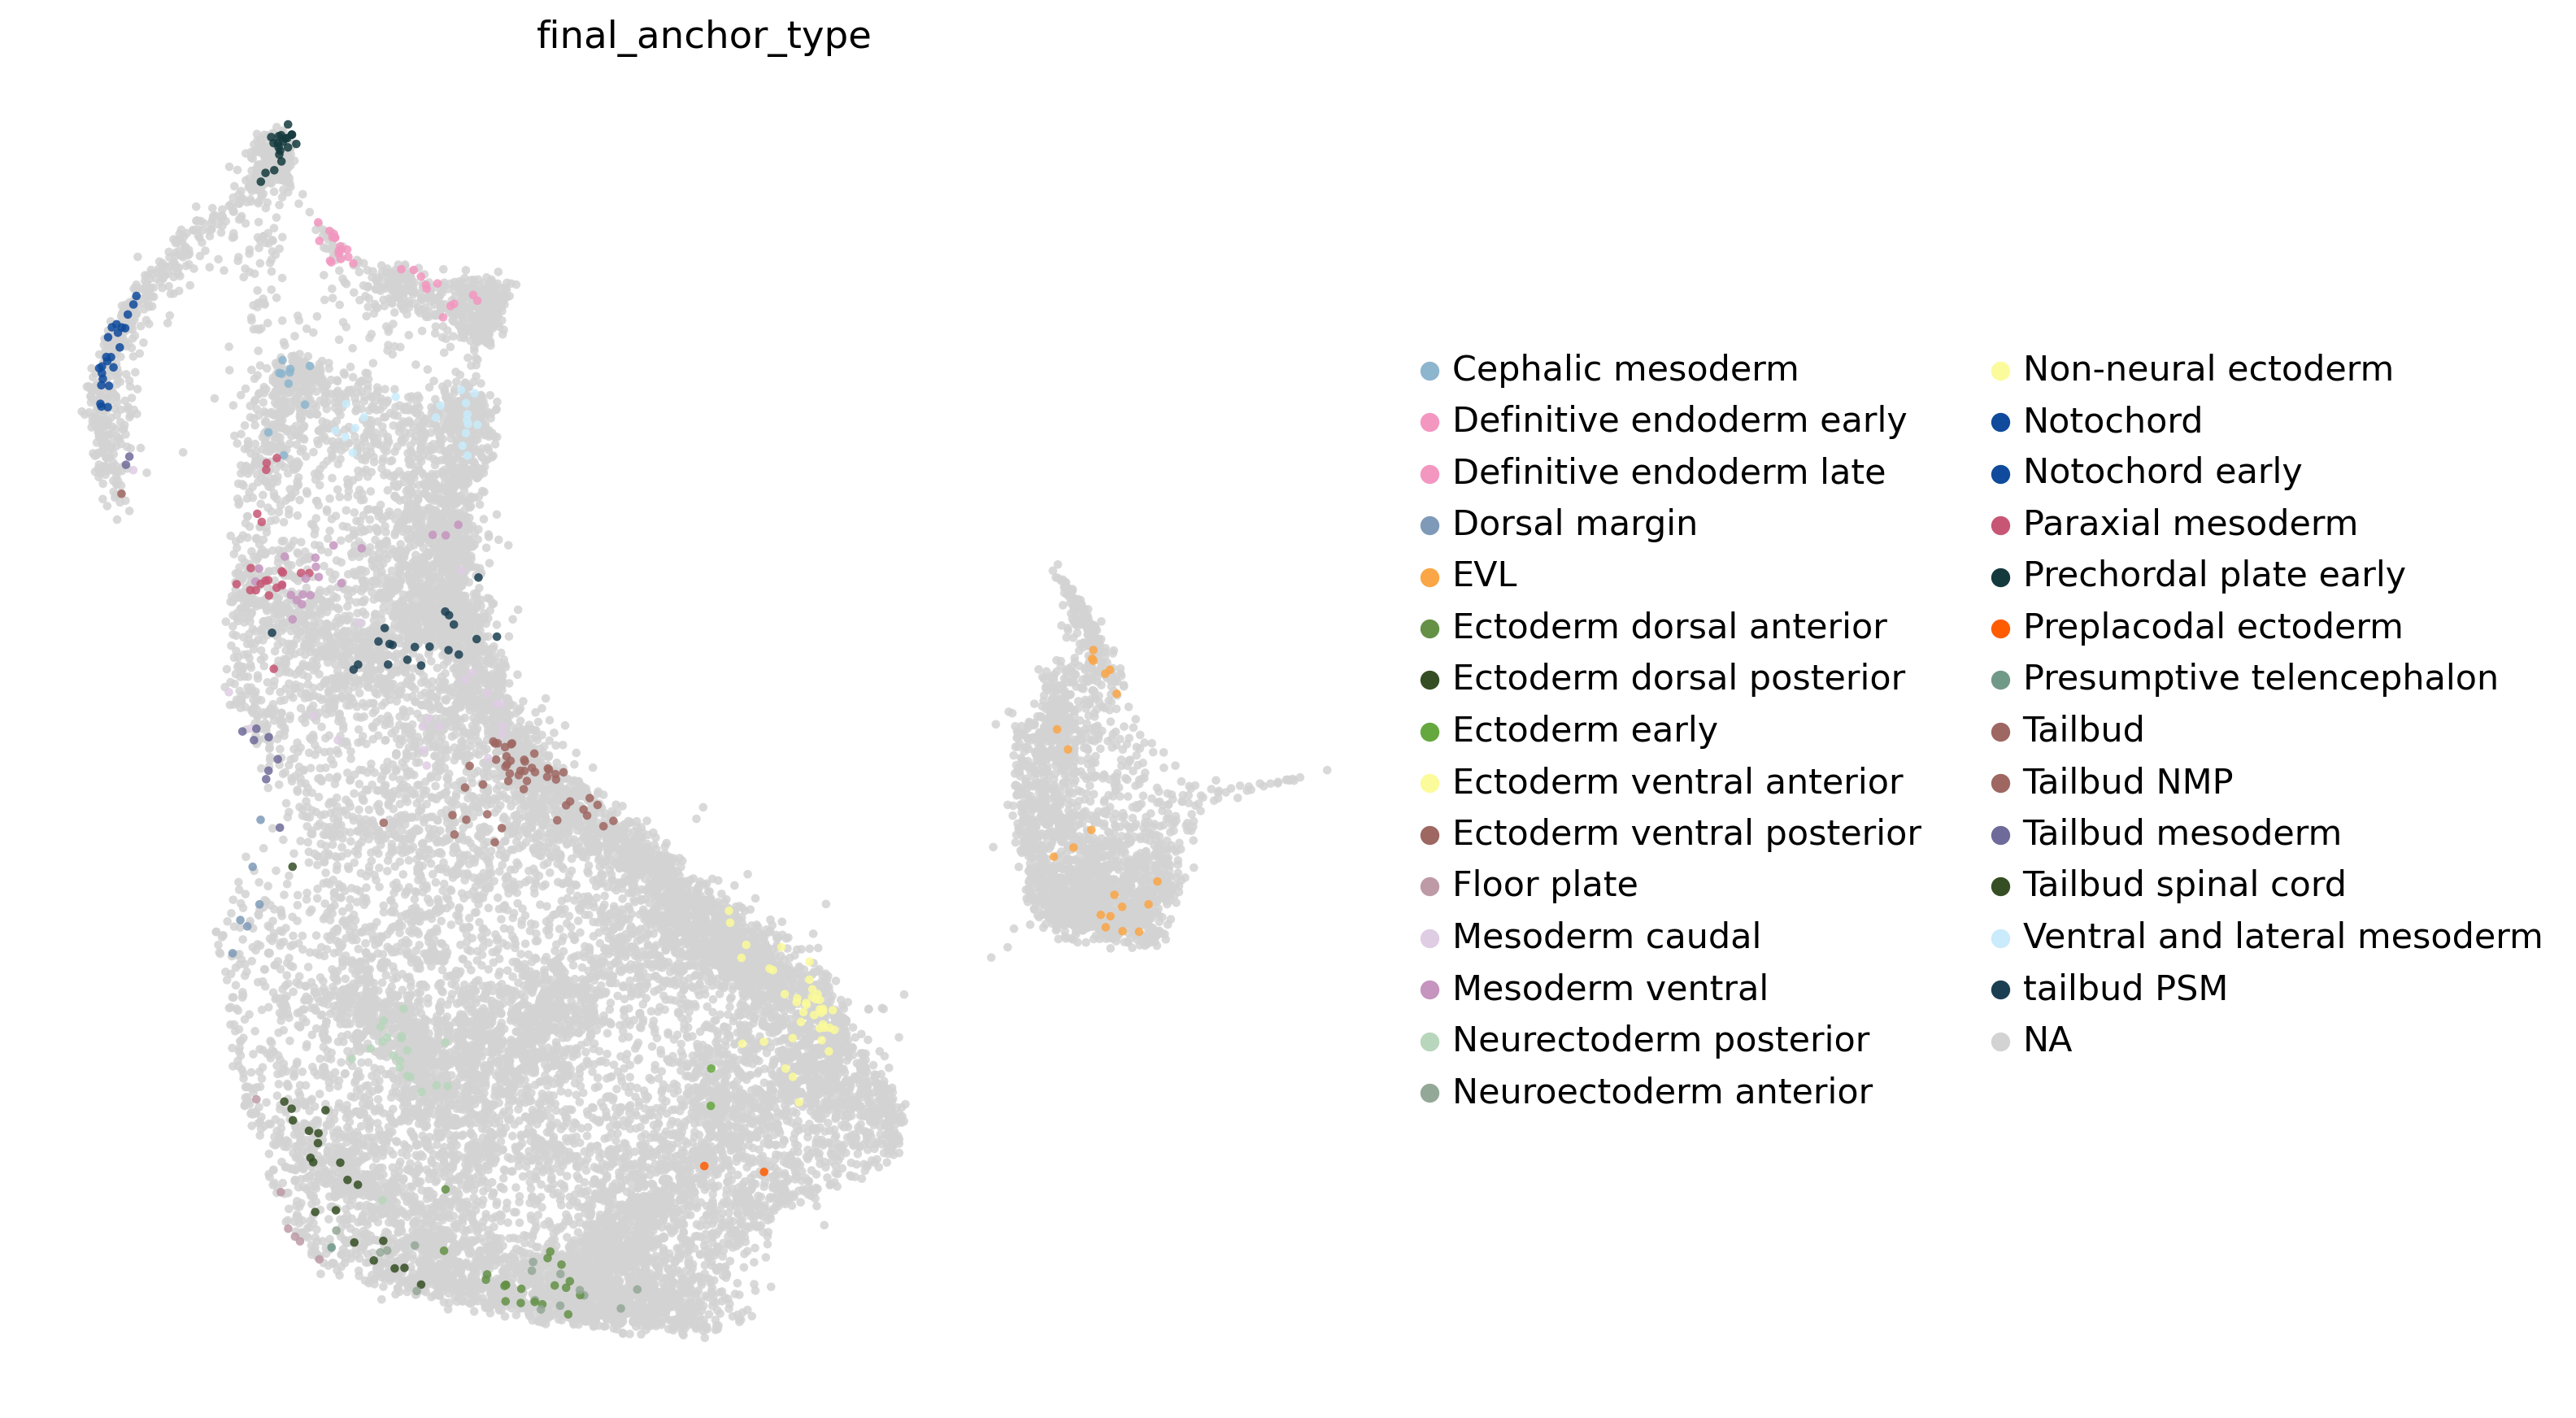

In [30]:
_ = mapping_sc_to_st.fig.plot_umap_st_types_and_anchors(
    adata_st,
    cell_type_color,
    st_type_key="global_sc_type",
    idx_anchor=idx_anchor,
    anchors_by_type=anchors_by_type,
    anchor_type_key="final_anchor_type",   # 결과가 adata_st.obs에 이 이름으로 생김
    fig_size=(9,9),
    umap_kwargs_common=dict(size=40, alpha=0.85, legend_loc="right margin", frameon=False),
)

# 4. Global FGW

This section performs a final **global refinement** using **anchor-based FGW**.  
The goal is to improve global consistency across *all* cell types, especially for spots that remain uncertain after pairwise refinement.

## Why we run a final global pass

Up to now, we refined the ST mapping using a score that measures how well each spot matches SC expression patterns.  
After the pairwise step, we already have a strong intermediate result: spots with high `final_pairwise_score` are usually reliable, and we can reuse them as “reference points”.

However, pairwise refinement is intentionally local. It only revisits spots inside selected two-type corridors `(ct1, ct2)`.  
This means it cannot fully handle situations like:
- a spot that could plausibly match **three or more** cell types, or
- errors that require **global consistency** across all types, not just within a single pair.

To address this, we perform one more **global FGW** update.

## Why anchors and Phi are needed

### The problem with a naive global FGW
FGW tries to find a transport plan between SC and ST by combining:
- a cross-domain matching cost $M$ (how similar SC and ST look), and
- a within-domain structure term (how geometry is preserved inside SC and inside ST).

In practice, SC and ST embeddings are not guaranteed to be directly comparable across domains, even if they have the same name (e.g., both stored as `X_scvi`).  
Because of this, a global optimization can become unstable if it relies only on expression matching plus geometry regularization: the solver may try to force two mismatched geometries to agree.

### Step 1: Turn high-score ST spots into anchors (landmarks)
Instead of trusting cross-domain geometry compatibility, we create landmarks:

- Choose a small set of ST spots that already look very reliable:
  - high `final_pairwise_score`
  - selected per type and geometry-diverse (to avoid bias)
- These spots become anchors: reference ST locations that represent each type.

Anchors are not assumed to be perfect ground truth, but they are strong evidence that we want the global step to respect.

### Step 2: Build Phi (anchor-distance signatures)
Phi represents each sample by its distances to the anchor set.

- For each ST spot $j$, Phi is a vector of distances to ST anchors:
  - $\Phi_{st}(j,k)=\|z^{st}_j - z^{st}_{a_k}\|_2$
- For each SC cell $i$, we build a comparable vector of distances to the SC-side versions of the same anchors.
  We construct an SC pseudo-center $c_k$ for anchor $k$ using the anchor spot’s mixture weights:
  - $c_k=\sum_m \tilde w_{k,m}\, z^{sc}_{i_{k,m}}$
  then define:
  - $\Phi_{sc}(i,k)=\|z^{sc}_i - c_k\|_2$

The key benefit is that SC and ST are now compared in the same $K$-dimensional space (“distances to the same landmarks”), which is more robust than comparing raw embedding coordinates.

### Step 3: Use Phi to define an anchor-based matching cost
Once we have Phi, we define a cross-domain cost that measures how similar the anchor-distance patterns are:
- $M_{\text{anchor}}(i,j)=\|\Phi_{sc}(i,\cdot)-\Phi_{st}(j,\cdot)\|_2^2$

This cost encourages SC cells that “sit in the right place relative to anchors” to match the ST spot.

### Step 4: Mix anchor-based cost with expression cost
Anchors can still be wrong. If we rely only on anchor structure, anchor mistakes can be amplified and become fixed.

Therefore we keep the original expression evidence $M_{\text{expr}}$ and mix the two:
- $M=\beta_{\text{expr}}\,\tilde{M}_{\text{expr}}+(1-\beta_{\text{expr}})\,\tilde{M}_{\text{anchor}}$

- $M_{\text{expr}}$: observation-driven guardrail (what the spot actually expresses)
- $M_{\text{anchor}}$: landmark-based structure (global consistency)

This combination lets the global step benefit from anchors when they are correct, while still being able to escape if an anchor is misleading.


### Why alignment is necessary for an anchor-based cost $M_{\text{anchor}}$

We want an anchor-based cross-domain cost that is meaningful:
- $M_{\text{anchor}}(i,j)$ should be small when SC cell $i$ and ST spot $j$ occupy consistent positions **relative to the same anchor landmarks**.

Phi makes this possible by mapping SC and ST into a shared $K$-dimensional “anchor-distance” space, but because SC anchors are constructed as pseudo-centers, the raw Phi distributions can differ in scale/offset across domains.  
Alignment calibrates this residual mismatch so that $M_{\text{anchor}}$ reflects structure rather than unit differences.

#### 1) Build anchors and geometry

Let:
- ST spots: $j \in \{1,\dots,n_{st}\}$
- SC cells: $i \in \{1,\dots,n_{sc}\}$
- ST anchors (indices in `adata_st`): $a_k \in \{1,\dots,n_{st}\}$ for $k=1,\dots,K$

Geometry embeddings:
- $z^{st}_j \in \mathbb{R}^d$ from `adata_st.obsm[st_geom_key]`
- $z^{sc}_i \in \mathbb{R}^d$ from `adata_sc.obsm[sc_geom_key]`

#### 2) Construct Phi for ST

For each ST spot $j$ and anchor $k$:
- $\Phi_{st}(j,k) = \| z^{st}_j - z^{st}_{a_k} \|_2$

So $\Phi_{st} \in \mathbb{R}^{n_{st} \times K}$.

#### 3) Construct SC pseudo-centers for anchors (transfer ST landmarks to SC)

Each ST spot (in particular each anchor spot) has a stored SC mixture from the previous stage:
- a set of SC indices $\{i_{k,m}\}_{m=1}^{M_k}$ and weights $\{w_{k,m}\}_{m=1}^{M_k}$

Normalize weights:
- $\tilde w_{k,m}=\frac{w_{k,m}}{\sum_{m'} w_{k,m'}+\epsilon}$

Define the SC pseudo-center for anchor $k$:
- $c_k = \sum_{m=1}^{M_k} \tilde w_{k,m}\, z^{sc}_{i_{k,m}}$

This is the step that “transfers” ST anchor landmarks into the SC embedding: anchors become SC reference points via the mixture barycenter.

#### 4) Construct Phi for SC

For each SC cell $i$ and anchor $k$:
- $\Phi_{sc}(i,k) = \| z^{sc}_i - c_k \|_2$

So $\Phi_{sc} \in \mathbb{R}^{n_{sc} \times K}$.

#### 5) Why raw Phi may still be mismatched

Even though both domains now live in the same $K$-dimensional space, the two Phi matrices can differ systematically because:
- ST uses true anchor coordinates $z^{st}_{a_k}$
- SC uses pseudo-centers $c_k$ (mixture-derived), which can alter variance/scale by type

So comparing $\Phi_{sc}$ and $\Phi_{st}$ directly may yield a cost dominated by scale/offset mismatch.

#### 6) Alignment: type-wise, per-axis affine calibration

We align SOURCE Phi to match TARGET Phi distribution.  
Here `direction="sc_to_st"` means SOURCE = SC and TARGET = ST.

Let:
- $t^{st}_j$ be the ST type label for spot $j$ (e.g., `final_pairwise_type`)
- $t^{sc}_i$ be the SC type label for cell $i$ (e.g., `cell_type`)

For each type $t$ and each anchor-axis $k$, we fit:
- $x' = \alpha_{t,k} x + \beta_{t,k}$

##### Global (fallback) calibration for each axis $k$
Using all training samples:
- $\alpha_{g,k} = \frac{\sigma^{tar}_k}{\sigma^{src}_k+\epsilon}$
- $\beta_{g,k} = \mu^{tar}_k - \alpha_{g,k}\mu^{src}_k$

where $(\mu^{src}_k,\sigma^{src}_k)$ are the mean/std of SOURCE values on axis $k$, and $(\mu^{tar}_k,\sigma^{tar}_k)$ are the mean/std on TARGET.

##### Type-specific calibration (only when enough samples)
If both domains have at least `min_n` samples for type $t$, fit:
- $\alpha_{t,k} = \frac{\sigma^{tar,(t)}_k}{\sigma^{src,(t)}_k+\epsilon}$
- $\beta_{t,k} = \mu^{tar,(t)}_k - \alpha_{t,k}\mu^{src,(t)}_k$

##### Shrinkage toward global calibration
To stabilize type-specific estimates:
- $w_t=\frac{n_t}{n_t+\max(1,\texttt{shrink\_k})}$
- $\alpha_{t,k} \leftarrow w_t \alpha_{t,k} + (1-w_t)\alpha_{g,k}$
- $\beta_{t,k} \leftarrow w_t \beta_{t,k} + (1-w_t)\beta_{g,k}$

With `shrink_k=1`, shrinkage is weak unless $n_t$ is very small.

##### Apply the calibration
For an SC cell $i$ of type $t=t^{sc}_i$:
- $\Phi_{sc}^{aligned}(i,k)=\alpha_{t,k}\,\Phi_{sc}(i,k)+\beta_{t,k}$

Optionally the implementation clips to robust TARGET quantiles and enforces non-negativity:
- $\Phi_{sc}^{aligned}(i,k)\leftarrow\max(0,\mathrm{clip}(\Phi_{sc}^{aligned}(i,k),Q_{low},Q_{high}))$

#### 7) Build the anchor-based cross-domain cost

Finally:
- $M_{\text{anchor}}(i,j)=\|\Phi_{sc}^{aligned}(i,\cdot)-\Phi_{st}(j,\cdot)\|_2^2$

This cost is then mixed with expression cost for FGW:
- $M=\beta_{\text{expr}}\tilde M_{\text{expr}}+(1-\beta_{\text{expr}})\tilde M_{\text{anchor}}$



In [ ]:
_ = mapping_sc_to_st.fig.plot_phi_umap(
    adata_sc=adata_sc,
    adata_st=adata_st,
    idx_anchor=idx_anchor,
    cell_type_color=cell_type_color,
    sc_geom_key="X_scvi",
    st_geom_key="X_scvi",
    min_n=30,
    shrink_k=10,
    direction="sc_to_st",
)

In [32]:
solver = mapping_sc_to_st.fgw_solver.POTFGWSolver(
    #method="entropic_semirelaxed_fgw",
    method = 'entropic_fgw',
    alpha=0.5,
    loss_fun="square_loss",
    epsilon = 0.005,
    #max_iter=10,     
    #max_iter_ot=2,   
    #unbalanced_solver="mm",
    #reg_marginals=10.0,
    #divergence="kl",
)


### `GlobalAnchorFGWConfig` parameters

This configuration controls the **final global, anchor-based FGW refinement**.

#### Thresholds
- `tau_anchor`  
  Score threshold used to **select anchor ST spots** (high-confidence landmarks).  
  *Example here:* median of `adata_st.obs["final_pairwise_score"]`.

- `tau_update`  
  Score threshold controlling which ST spots are **allowed to be updated** in the global step.  
  Higher values make the update more conservative (only very confident spots are changed).

#### Cost mixing
- `beta_expr` *(0–1)*  
  Mixes expression-driven and anchor-structure-driven costs:  
  $$
  M = \beta_{\text{expr}}\,\tilde M_{\text{expr}} + (1-\beta_{\text{expr}})\,\tilde M_{\text{anchor}}
  $$
  - Larger `beta_expr` → rely more on expression similarity  
  - Smaller `beta_expr` → rely more on anchor geometry / global consistency

#### Keys (where intermediate results are stored in `adata_st.obs`)
- `update_type_key`  
  Column name containing the current predicted type used during the global step (e.g., `"final_pairwise_type"`).

- `update_score_key`  
  Column name containing the confidence score for the current type (e.g., `"final_pairwise_score"`).

#### Anchor selection and alignment
- `anchor_k_per_type`  
  Max number of **anchors per type** to sample (after filtering by `tau_anchor`).

- `align_min_per_type`  
  Minimum number of samples per type required to fit **type-specific alignment** parameters.

- `use_alignment`  
  If `True`, apply the optional **affine calibration** between $\Phi_{sc}$ and $\Phi_{st}$ before building $M_{\text{anchor}}$.

- `alignment_direction`  
  Direction of the calibration:
  - `"sc_to_st"`: align SC $\Phi$ → ST $\Phi$
  - `"st_to_sc"`: align ST $\Phi$ → SC $\Phi$

- `alignment_shrink_k`  
  Shrinkage strength that pulls type-specific alignment toward a global alignment to reduce overfitting.

#### Geometry / normalization
- `sc_geom_key`, `st_geom_key`  
  `.obsm` keys used as geometry embeddings for SC and ST (both set to `X_scvi` here).

- `C_norm`  
  Normalization rule for geometry matrices (e.g., `"q95"` rescales distances by a robust high quantile).

#### Optional (commented in the code)
- `sc_C_mode`  
  Alternative SC geometry construction (e.g., metacell-based distances) if enabled.


In [33]:
cfg = mapping_sc_to_st.final_global_anchor_fgw.GlobalAnchorFGWConfig(
    
    tau_anchor = np.percentile(adata_st.obs["final_pairwise_score"].to_numpy(), 50),
    tau_update = 0.9,#np.percentile(adata_st.obs["final_pairwise_score"].to_numpy(), 50),
    beta_expr=0.5,
    update_type_key="final_pairwise_type",
    update_score_key="final_pairwise_score",
    use_alignment = True,
    anchor_k_per_type=30,                    
    align_min_per_type = 30,
    alignment_shrink_k = 40,
    #alignment_direction = "sc_to_st",
    alignment_direction = "st_to_sc",
    C_norm = "q95",
    sc_geom_key = 'X_scvi',
    st_geom_key = 'X_scvi',
    #sc_C_mode = 'metacell_distance',
)

### Run: final global anchor FGW update

This call performs the **final anchor-based FGW update** between `adata_sc` (single-cell reference) and `adata_st` (spatial target), using the configuration in `cfg` and the OT/FGW `solver`. It can optionally run **gene imputation** from sc → st using the learned mapping.

**Key inputs**
- `adata_sc`, `adata_st`: AnnData objects for single-cell and spatial data.
- `sc_type_key="cell_type"`: Column in `adata_sc.obs` that stores cell-type labels used for per-type anchoring / constraints.
- `cfg`: `GlobalAnchorFGWConfig` instance (thresholds, alignment direction, geometry keys, etc.).
- `solver`: FGW/OT solver settings (iterations, regularization, stopping criteria; depends on the solver object used in this notebook).
- `precomp=S["precomp"]`: Precomputed quantities reused across runs (e.g., normalized costs / geometry-dependent caches), to speed up computation.

**Optional gene set restriction**
- `incoming_obj=incoming_genes`: List/array of genes to consider as “incoming” candidates for update/imputation.
- `use_incoming_genes=True`: If `True`, restricts update/imputation to `incoming_obj`.

**Update safety checks**
- `cos_threshold=0.5`: Minimum cosine-similarity threshold used to accept candidate updates (higher = stricter).
- `update_only_if_improved=True`: If `True`, applies an update only when the objective / score improves compared to the current state.

**Imputation options**
- `compute_imputation=True`: Computes sc → st imputed expression based on the learned coupling.
- `store_imputation_dense=True`: Stores imputation as a dense matrix (faster downstream access; higher memory).
- `store_imputation_dict=True`: Also stores a sparse/dictionary-style representation (memory-friendly for selective access).

**Output**
- `out`: A dict-like result containing the updated coupling / anchors, updated `adata_st.obs` fields (depending on `cfg` keys), and optional imputation artifacts.


In [34]:
out = mapping_sc_to_st.final_global_anchor_fgw.run_final_global_anchor_fgw_update(
    adata_sc,
    adata_st,
    sc_type_key="cell_type",
    cfg=cfg,
    solver=solver,
    precomp=S['precomp'],
    incoming_obj=incoming_genes,      
    use_incoming_genes=True,
    cos_threshold=0.5,              
    update_only_if_improved=True,

    # imputation
    compute_imputation=True,
    store_imputation_dense=True,
    store_imputation_dict=True,
)

[final_global_anchor_fgw] Step 0/12: Start + validate inputs
[final_global_anchor_fgw]  n_sc=11401, n_st=18019
[final_global_anchor_fgw]  tau_anchor=0.7177784442901611, tau_update=0.9, beta_expr=0.5
[final_global_anchor_fgw]  allow_anchor_update=True
[final_global_anchor_fgw]  prev_weights_key='final_pairwise_weights'
[final_global_anchor_fgw]  alignment: use=True, direction='st_to_sc'
[final_global_anchor_fgw] Step 1/12: Initialize output columns (type snapshot -> working output)
[final_global_anchor_fgw] Step 2/12: Select anchors
[final_global_anchor_fgw]  anchors=745
[final_global_anchor_fgw] Step 3/12: Select update spots
[final_global_anchor_fgw]  updates=18019
[final_global_anchor_fgw] Step 4/12: Define SC candidates
[final_global_anchor_fgw]  sc_candidates=11401
[final_global_anchor_fgw] Step 5/12: Prepare expression features (M_expr built in run_transport)
[final_global_anchor_fgw] Step 7/12: Build pseudo-anchor cost M_anchor from prev weights (cached A-format)
[final_global_an

# 5. Results

- This section summarizes and visualizes the mapping outputs produced in the previous steps.

The notebook keeps **three** predicted labels / scores on the ST AnnData (`adata_st.obs`) so you can compare quality across stages:

1. **Global 1:1 mapping (stage 1)** 
 - **Label:** `global_sc_type` 
 - **Score:** `global_sc_sim` 
 Each ST spot is assigned the *single best-matching* reference cell (top‑1) based on expression similarity.

2. **Pairwise refinement (stage 2)** 
 - **Label:** `final_pairwise_type` 
 - **Score:** `final_pairwise_score` 
 This step explicitly refines assignments for cell-type pairs that are frequently confused (often due to *bleeding* or close transcriptional similarity).

3. **Global anchor-based FGW refinement (stage 3 / final)** 
 - **Label:** `global_final_type` 
 - **Score:** `global_final_score` 
 Anchor-based FGW improves global consistency by combining expression similarity with dataset structure.


### Figures generated below

- **Score boxplots (by cell type):** compare `global_sc_sim` vs `final_pairwise_score` vs `global_final_score` for each cell type. 
 Cell types that improve across stages are those for which refinement resolved ambiguity.

- **UMAP panels (ST):** show ST spots colored by the predicted cell type at each stage. 
 Look for increased spatial coherence (cleaner regions / fewer scattered mislabeled spots) from left to right.

- **Gene-wise correlation (observed ST vs imputed reference):** 
 `compute_ct_stage_specific_and_all_gene_corr(...)` evaluates how well *imputed expression* from each stage matches measured ST expression.
 The printed values (`corr_stage1`, `corr_stage2`, `corr_fgw`) are **max gene-wise Pearson correlations** across the panel genes; the boxplot is more informative for overall trends.

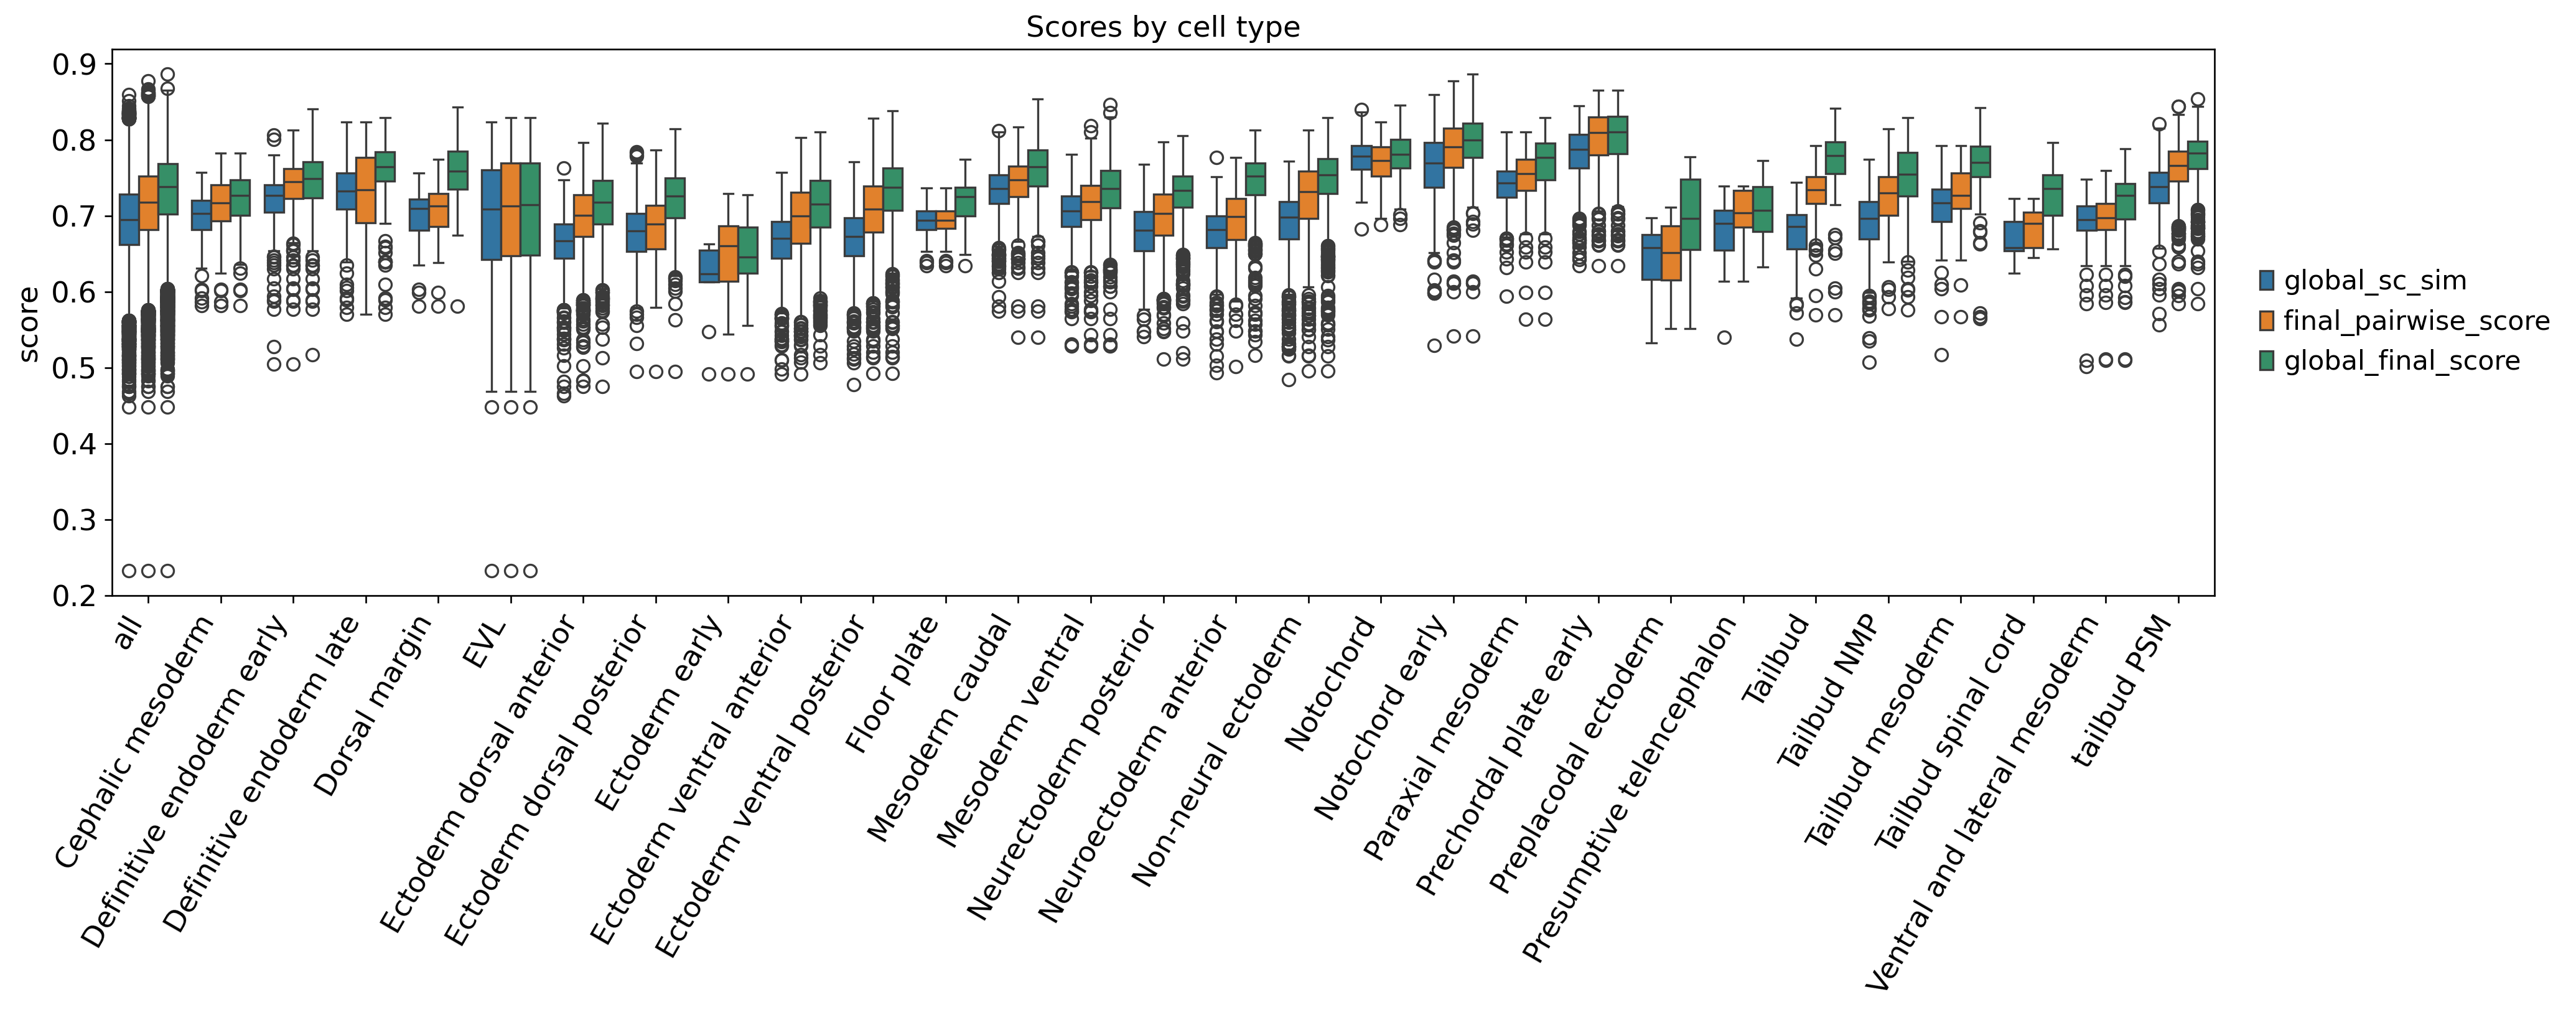

In [35]:
df_long, fig, ax = mapping_sc_to_st.fig.sim_score_box_plot(
    adata_st,
    pairs=[
        {"type_key": "global_sc_type", "score_key": "global_sc_sim", "label": "global_sc_sim"},
        {"type_key": "final_pairwise_type", "score_key": "final_pairwise_score", "label": "final_pairwise_score"},
        {"type_key": "global_final_type", "score_key": "global_final_score", "label": "global_final_score"},
    ],
    include_all=True,
    type_mode="intersection",
    figsize=(22, 6),
    rotate_xticks=60,
)


[plot_umap_with_category_colors] key='global_sc_type'
  n_obs=18019, n_categories=28
  missing in color_map: []
[plot_umap_with_category_colors] key='final_pairwise_type'
  n_obs=18019, n_categories=28
  missing in color_map: []
[plot_umap_with_category_colors] key='global_final_type'
  n_obs=18019, n_categories=29
  missing in color_map: []


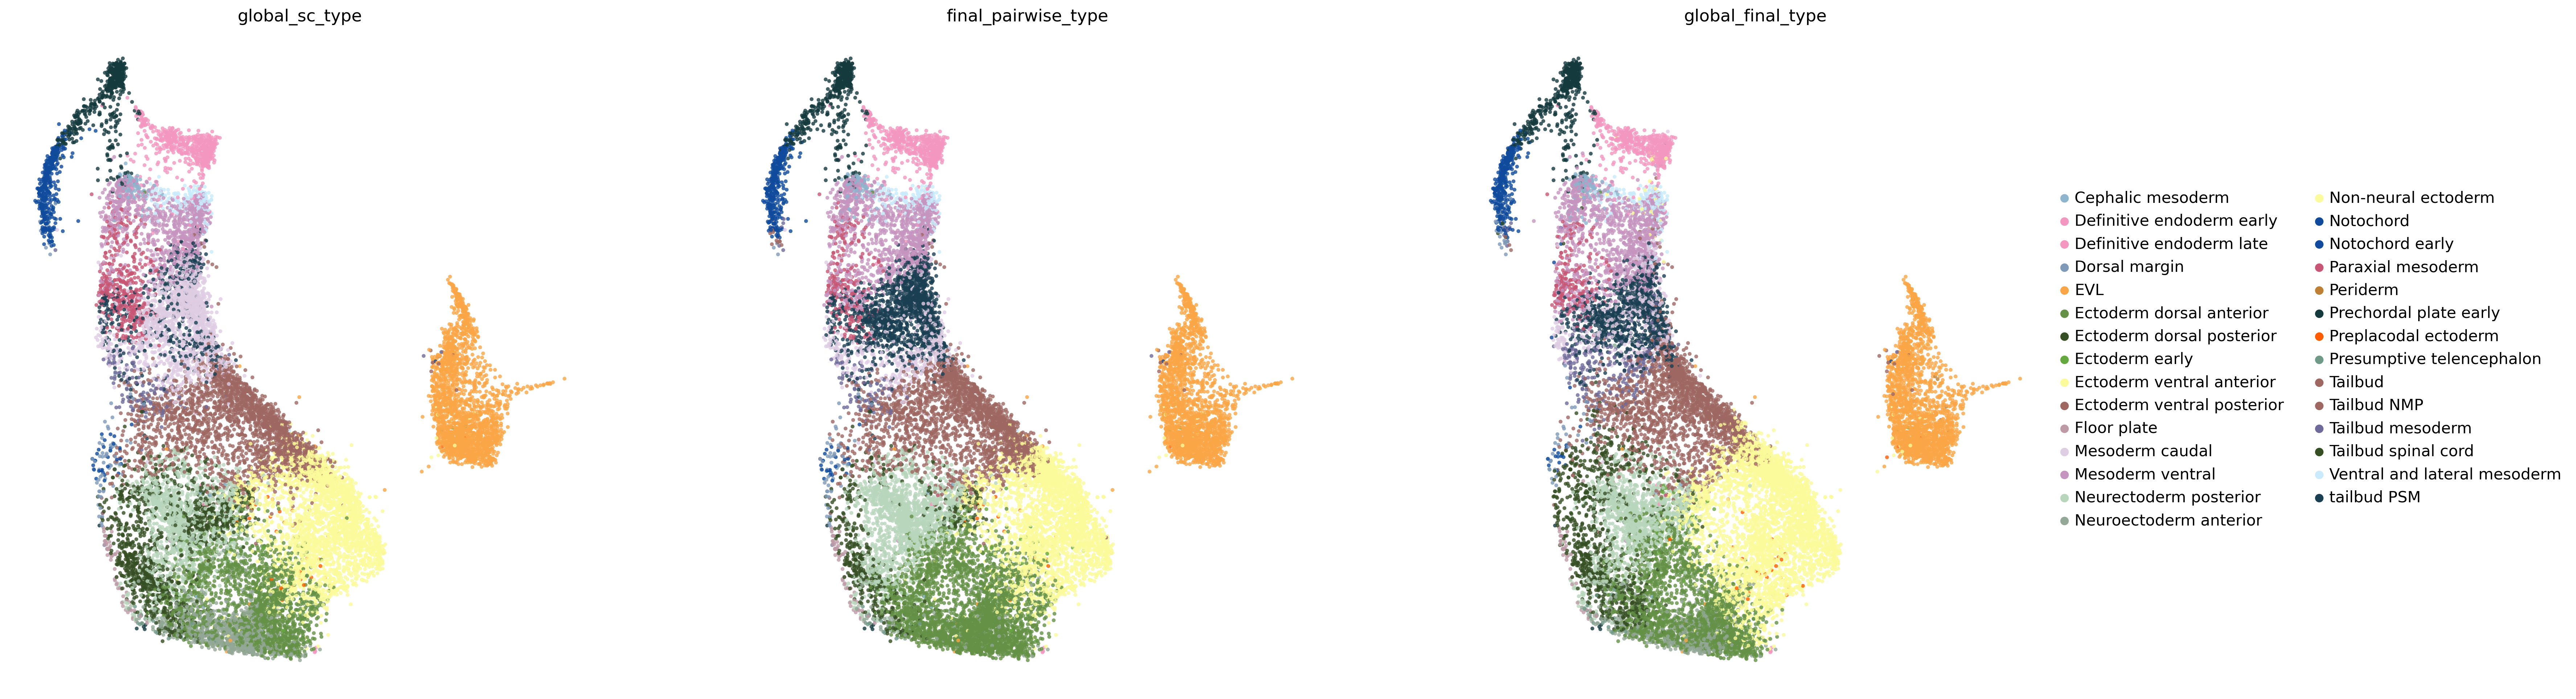

In [36]:
_ = mapping_sc_to_st.fig.plot_umap_st_cell_type(
    adata_st,
    cell_type_color=cell_type_color,
    keys=("global_sc_type","final_pairwise_type","global_final_type"),
    umap_kwargs_common=dict(size=40, alpha=0.8, legend_loc="right margin", frameon=False),
    fig_size=(30, 10),
)

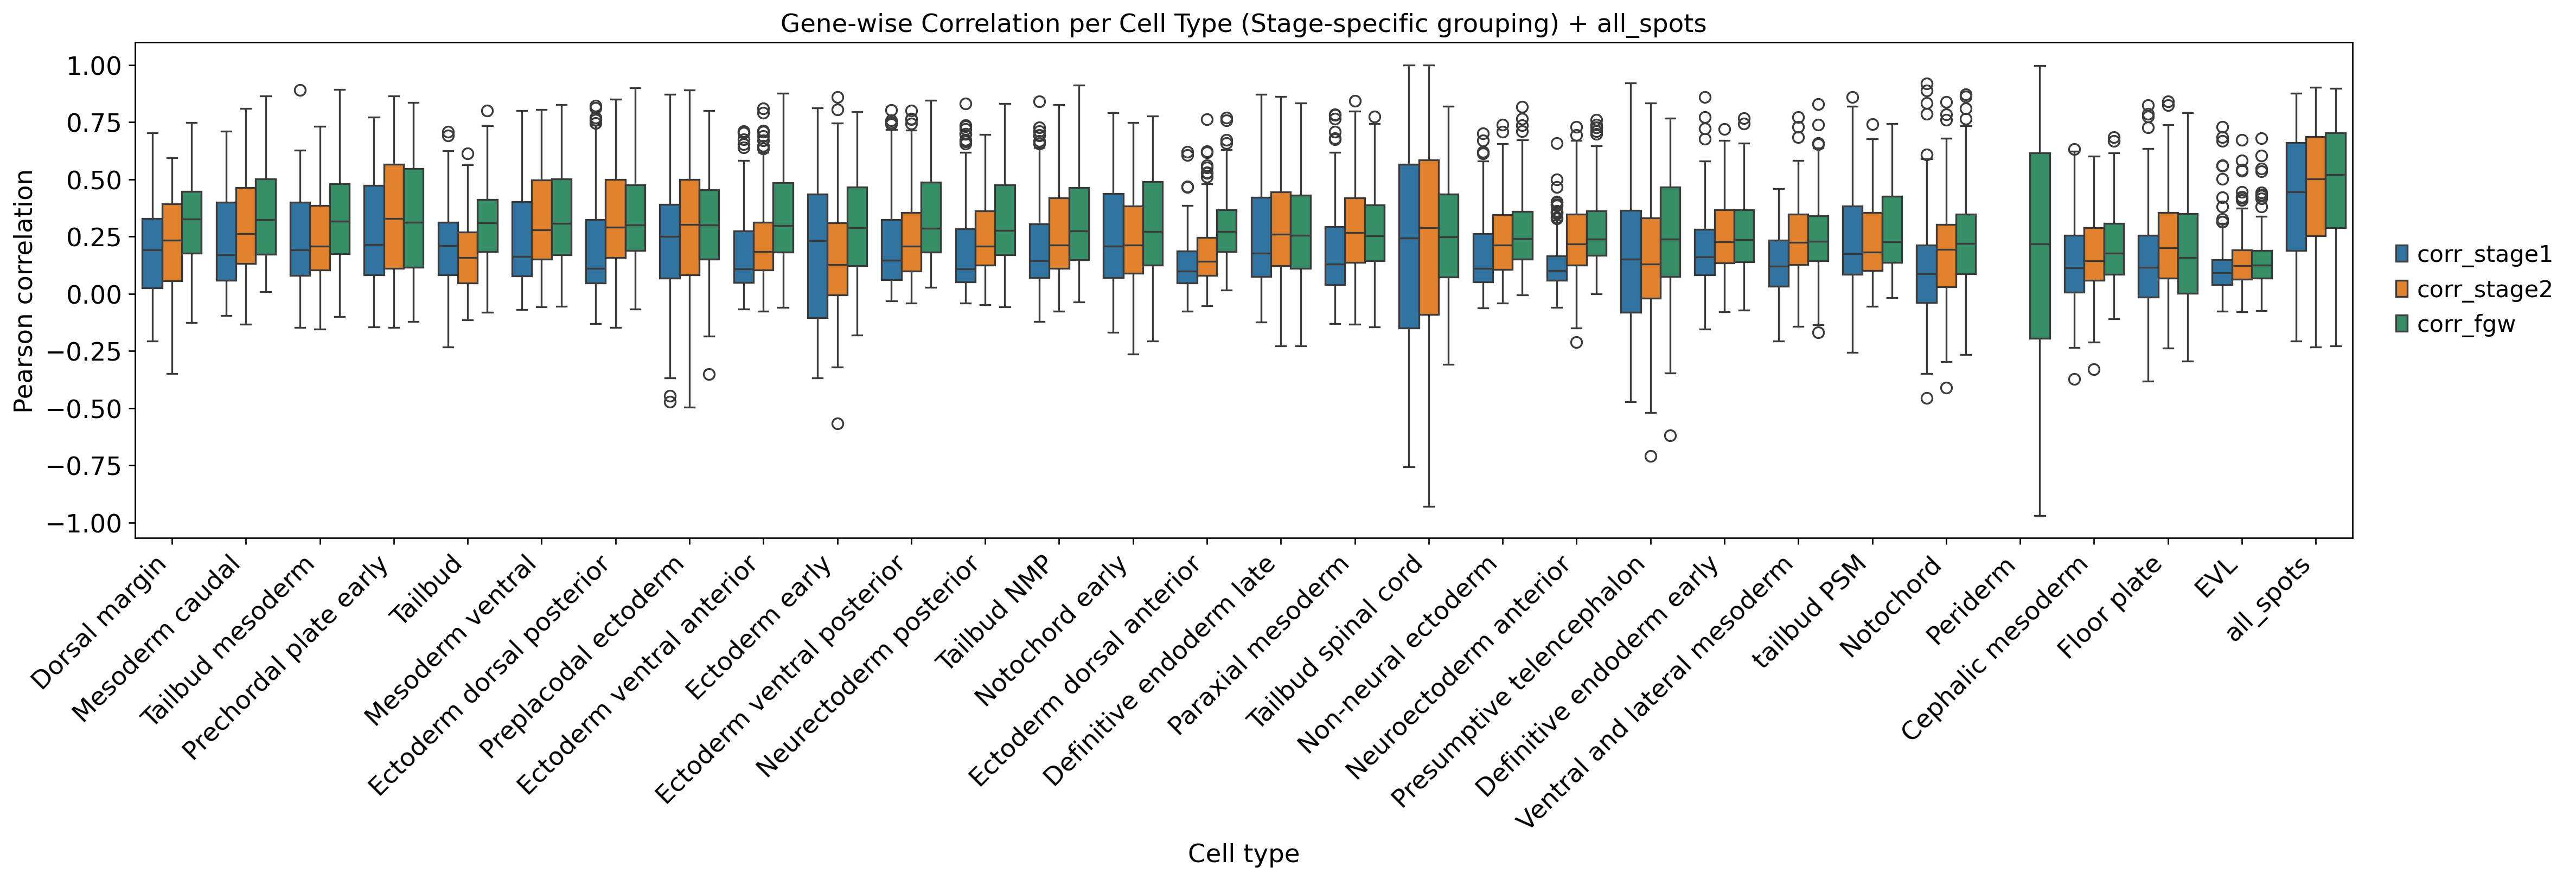

In [37]:
df_ct_stage, df_all = mapping_sc_to_st.gene_correlation.compute_ct_stage_specific_and_all_gene_corr(
    adata_sc=adata_sc,
    adata_st=adata_st,
    deg_results=deg_results,
    bleeding_results=incoming_genes,
    min_spots=1,
    min_genes=1,
    min_n_corr=1,
)

fig, ax, df_used = mapping_sc_to_st.fig.plot_gene_wise_corr_stage_specific_boxplot(
    df_ct_stage=df_ct_stage,   # long (stage-specific)
    df_all_wide=df_all,        # wide (all_spots)
    include_all=True,
    all_labels=("all_spots", "all"),
)

In [ ]:
with open(file='my_result_gene_corr.pickle', mode='wb') as f:
    pickle.dump(df_all['corr_fgw'].to_list(), f)